In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras import layers, Model, Input

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data
data_path = '/content/drive/MyDrive/dataset'
file_path = f'{data_path}/Galaxy10_DECals.h5'
with h5py.File(file_path, 'r') as f:
    images = np.array(f['images']) # load as unit8
    labels = np.array(f['ans'])

    redshift = np.array(f['redshift'])


print(f"Images shape: {images.shape}")  # Expected: (17736, 256, 256, 3)
print(f"Labels shape: {labels.shape}")  # Expected: (17736,)

print(f"Redshift shape: {redshift.shape}")

Images shape: (17736, 256, 256, 3)
Labels shape: (17736,)
Redshift shape: (17736,)


In [ ]:
# 1.a.: Inspect redshift values
print("Checking redshift for invalid values...")
print(f"images min: {images.min():.4f}, max: {images.max():.4f}")
print(f"Nan labels: {np.isnan(labels).sum():.4f}, Unique Classes: {np.unique(labels)}")

print(f"NaN count: {np.isnan(redshift).sum()}, Inf count: {np.isinf(redshift).sum()}")
print(f"Redshift min: {np.min(redshift):.4f}, max: {np.max(redshift):.4f}")


Checking redshift for invalid values...
images min: 0.0000, max: 255.0000
Nan labels: 0.0000, Unique Classes: [0 1 2 3 4 5 6 7 8 9]
NaN count: 92, Inf count: 0
Redshift min: nan, max: nan


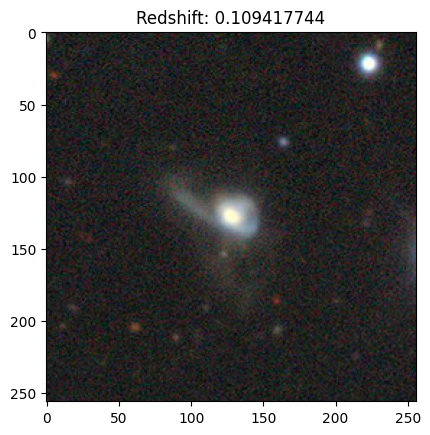

In [ ]:
idx = 2 # example index
plt.imshow(images[idx])
plt.title(f"Redshift: {redshift[idx]}")
plt.show()


In [ ]:
class_names = ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth',
               'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral','Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']

num_classes = len(class_names)

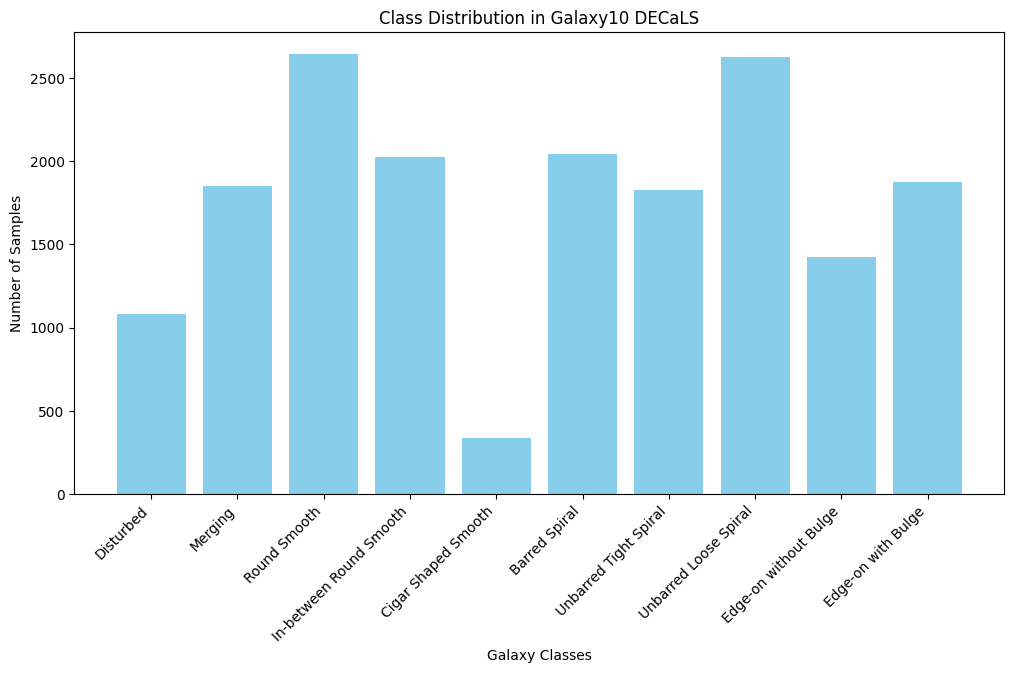

Class Distribution:
Disturbed: 1081
Merging: 1853
Round Smooth: 2645
In-between Round Smooth: 2027
Cigar Shaped Smooth: 334
Barred Spiral: 2043
Unbarred Tight Spiral: 1829
Unbarred Loose Spiral: 2628
Edge-on without Bulge: 1423
Edge-on with Bulge: 1873


In [ ]:
# distributio of galaxies
# 1.b.Class Distribution( class imbalance)
label_counts = Counter(labels)
plt.figure(figsize=(12, 6))
plt.bar(class_names, [label_counts.get(i, 0) for i in range(10)], color='skyblue')
plt.xlabel('Galaxy Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Galaxy10 DECaLS')
plt.xticks(rotation=45, ha='right')
#plt.savefig(f'{data_path}/class_distribution_decals.png')
plt.show()


print("Class Distribution:")
for i, name in enumerate(class_names):
    print(f"{name}: {label_counts.get(i, 0)}")

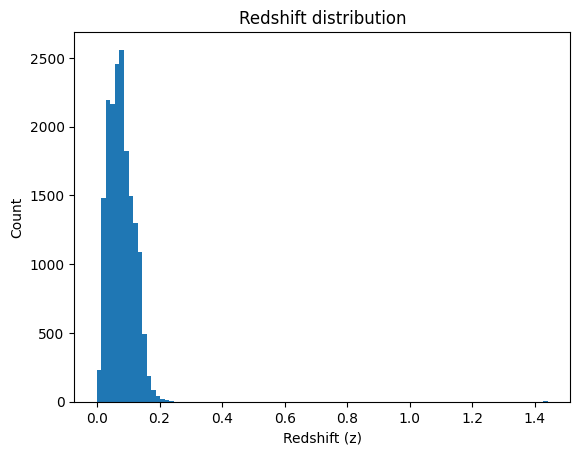

In [ ]:
#1.c.Resdhift distribution
plt.hist(redshift, bins=100)
plt.xlabel("Redshift (z)")
plt.ylabel("Count")
plt.title("Redshift distribution")
plt.show()

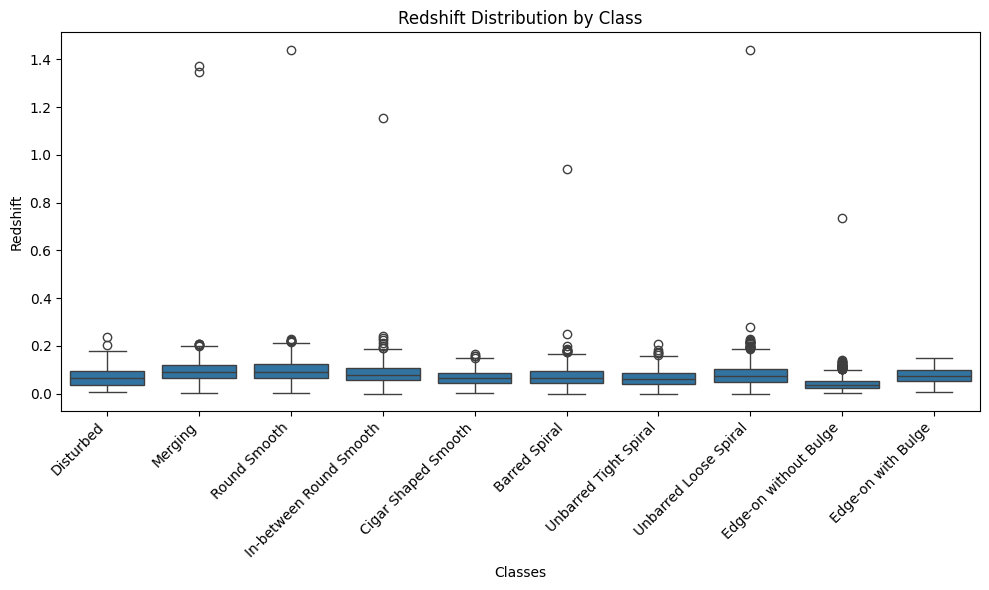

In [ ]:
# 1.d.Redshift Distribution by Class
plt.figure(figsize=(10, 6))
# Map the integer labels to class names for the x-axis using the labels
x_labels = [class_names[label] for label in labels]
# Use the redshift_raw
sns.boxplot(x=x_labels, y=redshift.flatten(),  legend=False )
plt.xlabel('Classes')
plt.ylabel('Redshift')
plt.title('Redshift Distribution by Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

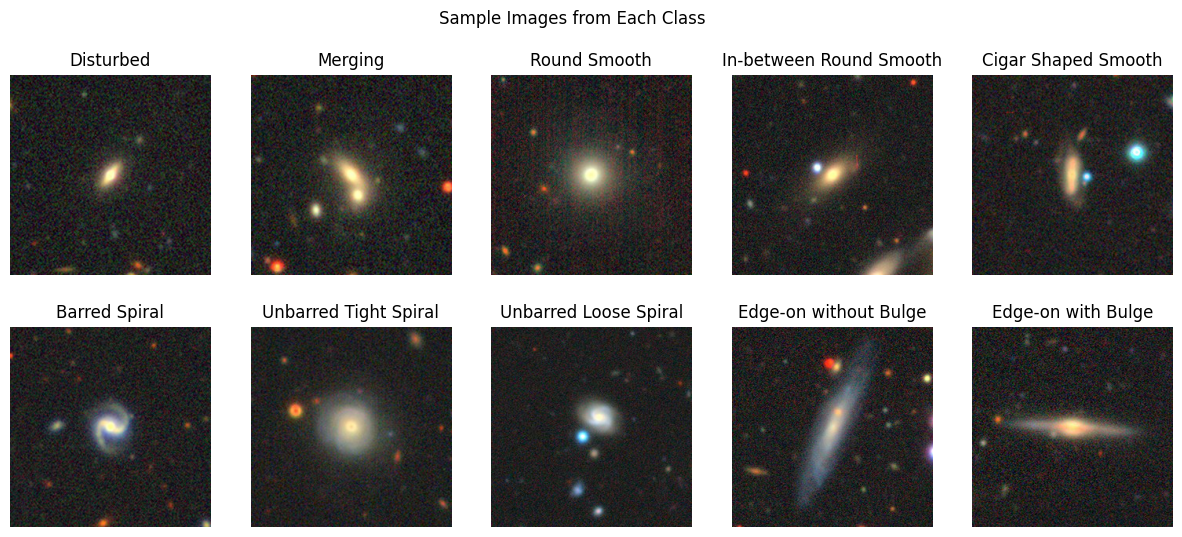

In [ ]:
# 1.e.Sample images from ecah Classes(raw samples)
plt.figure(figsize=(15, 6))# random samples for show
for i in range(10):
    idx = np.random.choice(np.where(labels== i)[0])
    plt.subplot(2, 5, i+1)
    img = images[idx]
    plt.imshow(img, vmin=0, vmax=1)  # ensure proper scaling
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

In [ ]:
#1.f. Pixel intensity stats of images
print("Pixel value range:", images.min(), images.max(), images.dtype)

Pixel value range: 0 255 uint8


In [ ]:
#step 2: Data cleaning process
# 2.a.Copy to avoid modifying original
redshift_clean = redshift.copy()

#a: Drop rows with NaN values
valid_mask = ~np.isnan(redshift_clean)
print(f"Removing {len(redshift_clean) - valid_mask.sum()} NaN rows")
redshift_clean = redshift_clean[valid_mask]
images_clean = images[valid_mask]        # Keep matching images
labels_clean = labels[valid_mask]


print("After cleaning:")
print("NaN count:", np.isnan(redshift_clean).sum())
print("Inf count:", np.isinf(redshift_clean).sum())
print("Min of redshift:", redshift_clean.min(), "Max of redshift:", redshift_clean.max())
print("Mean of redshift:", redshift_clean.mean(), "Std of redshift:", redshift_clean.std())

print(f"redshift_clean shape: {redshift_clean.shape}")
print(f"images_clean shape: {images_clean.shape}")
print(f"labels_clean shape: {labels_clean.shape}")

Removing 92 NaN rows
After cleaning:
NaN count: 0
Inf count: 0
Min of redshift: -0.0001244358 Max of redshift: 1.441647
Mean of redshift: 0.07750321706732066 Std of redshift: 0.04469131978755938
redshift_clean shape: (17644,)
images_clean shape: (17644, 256, 256, 3)
labels_clean shape: (17644,)


In [ ]:
# 2.b.FILTER: 0.0 < z < 1.5 (remove stars & high-z)
z_mask = (redshift_clean > 0.0) & (redshift_clean < 1.5)
print(f"Removing {len(redshift_clean) - z_mask.sum()} outlier z values")

redshift_clean = redshift_clean[z_mask]
images_clean = images_clean[z_mask]
labels_clean = labels_clean[z_mask]

print(f"redshift_clean shape: {redshift_clean.shape}")
print(f"images_clean shape: {images_clean.shape}")
print(f"labels_clean shape: {labels_clean.shape}")

Removing 3 outlier z values
redshift_clean shape: (17641,)
images_clean shape: (17641, 256, 256, 3)
labels_clean shape: (17641,)


In [ ]:
# Final stats after cleaning
print("\nAfter CORRECT cleaning:")
print("NaN count:", np.isnan(redshift_clean).sum())
print("Inf count:", np.isinf(redshift_clean).sum())
print("Min of redshift:", redshift_clean.min(), "Max of redshift:", redshift_clean.max())
print("Mean of redshift clean:", redshift_clean.mean(), "Std of redshift clean:", redshift_clean.std())
print(f"Final dataset size: {len(redshift_clean)}")


After CORRECT cleaning:
NaN count: 0
Inf count: 0
Min of redshift: 4.1589286e-05 Max of redshift: 1.441647
Mean of redshift clean: 0.07751640419316398 Std of redshift clean: 0.044683676641652285
Final dataset size: 17641


In [ ]:
# Normalize to [0,1] for stable training
z_min, z_max = redshift_clean.min(), redshift_clean.max()
redshift_norm = (redshift_clean - z_min) / (z_max - z_min)

print(f"Final redshift norm: mean={redshift_norm.mean():.3f}, std={redshift_norm.std():.3f}")
# Should be: mean ≈ 0.4, std ≈ 0.3 (healthy spread)

Final redshift norm: mean=0.054, std=0.031


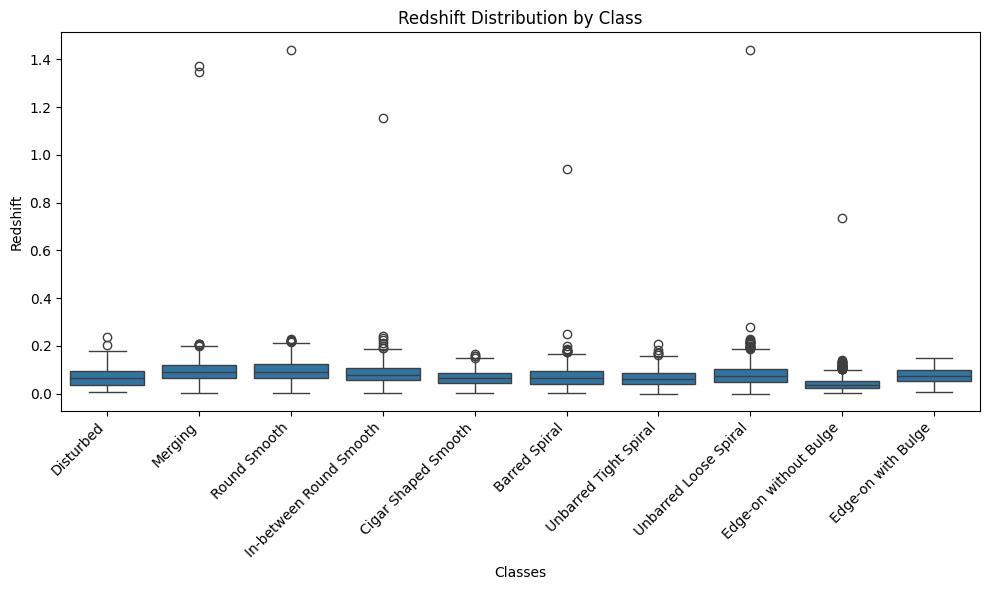

In [ ]:
# 4.4: Redshift by Class(before scalling)
import seaborn as sns
import gc
plt.figure(figsize=(10, 6))
# Map the integer labels to class names for the x-axis using the cleaned labels
x_labels = [class_names[label] for label in labels_clean]
# Use the cleaned redshift_raw
sns.boxplot(x=x_labels, y=redshift_clean.flatten())
plt.xlabel('Classes')
plt.ylabel('Redshift')
plt.title('Redshift Distribution by Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() # Adjust layout to prevent labels overlapping
#plt.savefig(f'{data_path}/redshift_by_class_decals.png')
#plt.close()
#print("EDA plot saved: redshift_by_class_decals.png")

gc.collect()
plt.show()

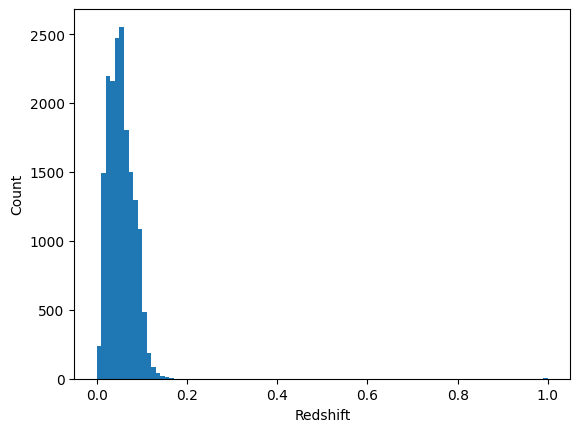

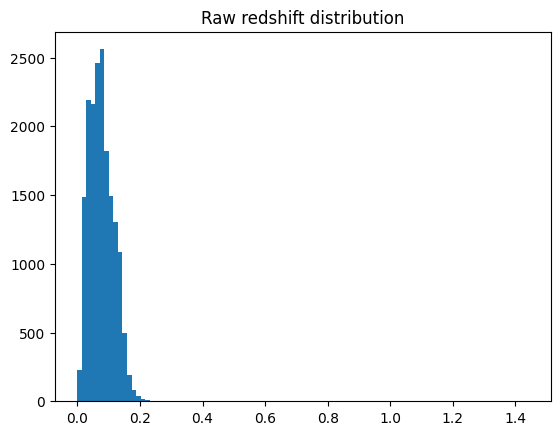

In [ ]:
# Distribution of redshift after cleaning and before cleaning

plt.hist(redshift_norm, bins=100)
plt.xlabel("Redshift")
plt.ylabel("Count")
plt.show()
plt.hist(redshift, bins=100)
plt.title("Raw redshift distribution")
plt.show()

In [ ]:
# Step 3: Batch Resize Images/ Normalize Image
# a. Normalizing the images

batch_size = 500
num_samples = images_clean.shape[0]
resized_images = np.zeros((num_samples, 64, 64, 3), dtype=np.float32)

print("Resizing images in batches...")
for i in range(0, num_samples, batch_size):
    end_idx = min(i + batch_size, num_samples)
    batch = images_clean[i:end_idx].astype('float32')  # Normalize in batch
    resized_batch = tf.image.resize(batch, [64, 64], method='bilinear').numpy()/255
    resized_images[i:end_idx] = resized_batch
    print(f"Processed batch {i//batch_size + 1}/{(num_samples-1)//batch_size + 1}")
    del batch, resized_batch  # Free memory
    gc.collect()

images = resized_images
#labels = labels_clean
print(f"After resizing, Images shape: {images.shape}, Labels shape: {labels.shape}")
print(f"Normalized images clean min: {images.min():.4f}, max: {images.max():.4f}")


Resizing images in batches...
Processed batch 1/36
Processed batch 2/36
Processed batch 3/36
Processed batch 4/36
Processed batch 5/36
Processed batch 6/36
Processed batch 7/36
Processed batch 8/36
Processed batch 9/36
Processed batch 10/36
Processed batch 11/36
Processed batch 12/36
Processed batch 13/36
Processed batch 14/36
Processed batch 15/36
Processed batch 16/36
Processed batch 17/36
Processed batch 18/36
Processed batch 19/36
Processed batch 20/36
Processed batch 21/36
Processed batch 22/36
Processed batch 23/36
Processed batch 24/36
Processed batch 25/36
Processed batch 26/36
Processed batch 27/36
Processed batch 28/36
Processed batch 29/36
Processed batch 30/36
Processed batch 31/36
Processed batch 32/36
Processed batch 33/36
Processed batch 34/36
Processed batch 35/36
Processed batch 36/36
After resizing, Images shape: (17641, 64, 64, 3), Labels shape: (17736,)
Normalized images clean min: 0.0000, max: 1.0000


In [ ]:
# Step 1: Reshape redshift to (B, 1, 1, 1)
z_scalar = redshift_norm[:, np.newaxis, np.newaxis, np.newaxis]  # (17641, 1, 1, 1)

# Step 2: Tile to (B, 64, 64, 1)
redshift_map = np.tile(z_scalar, (1, 64, 64, 1))  # (17641, 64, 64, 1)

# Step 3: Concatenate with images
images_4ch = np.concatenate([images, redshift_map], axis=-1)  # (17641, 64, 64, 4)

print(f"Final 4-channel shape: {images_4ch.shape}")  #  (17641, 64, 64, 4)

Final 4-channel shape: (17641, 64, 64, 4)


In [ ]:
# Check original pixel range after normalization
print(images_4ch.min(), images_4ch.max(), images_4ch.dtype)


0.0 1.0 float64


In [ ]:
# # b. Normalize metadata(Redshift)
# from sklearn.preprocessing import RobustScaler
# # Create separate scalers
# redshift_scaler = RobustScaler()
# #Fit and transform separately
# redshift_norm = redshift_scaler.fit_transform(redshift_clean.reshape(-1, 1)).flatten()


In [ ]:
# #PRINT THE VARIABLES
# print(f"redshift_norm shape: {redshift_norm.shape}")
# print(f"redshift_norm, mean = {redshift_norm.mean():.6f}, std = {redshift_norm.std():.6f}")
# print(f"redshift_norm, min = {redshift_norm.min():.6f}, max = {redshift_norm.max():.6f}")

redshift_norm shape: (17556,)
redshift_norm, mean = 0.066664, std = 0.668552
redshift_norm, min = -1.115979, max = 3.633405


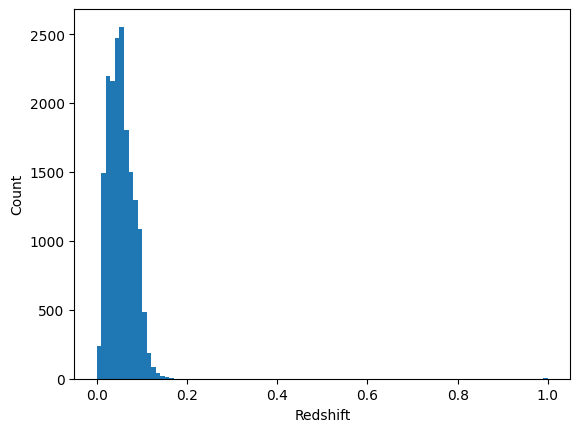

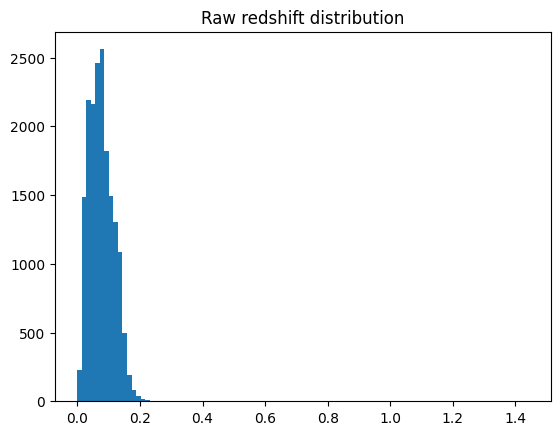

In [ ]:
# EDA:Distribution of redshift after normalization
plt.hist(redshift_norm, bins=100)
plt.xlabel("Redshift")
plt.ylabel("Count")
plt.show()
plt.hist(redshift, bins=100)
plt.title("Raw redshift distribution")
plt.show()

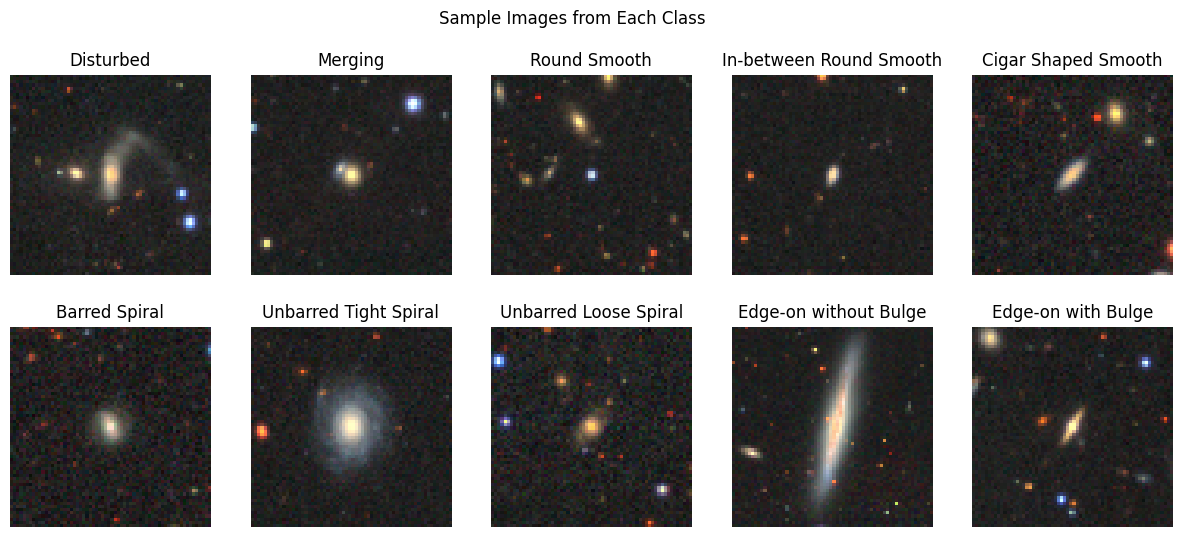

In [ ]:
# EDA: Sample Images after normalization
plt.figure(figsize=(15, 6))
for i in range(10):
    idx = np.where(labels== i)[0][0]
    plt.subplot(2, 5, i+1)
    img_to_show = images[idx]

    if img_to_show.max() <=1.0:
        img_to_show = img_to_show

    else:
        img_to_show = img_to_show/255.0
    plt.imshow(img_to_show, vmin=0, vmax=1)
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle('Sample Images from Each Class')
#plt.savefig(f'{data_path}/sample_images_decals.png')
plt.show()

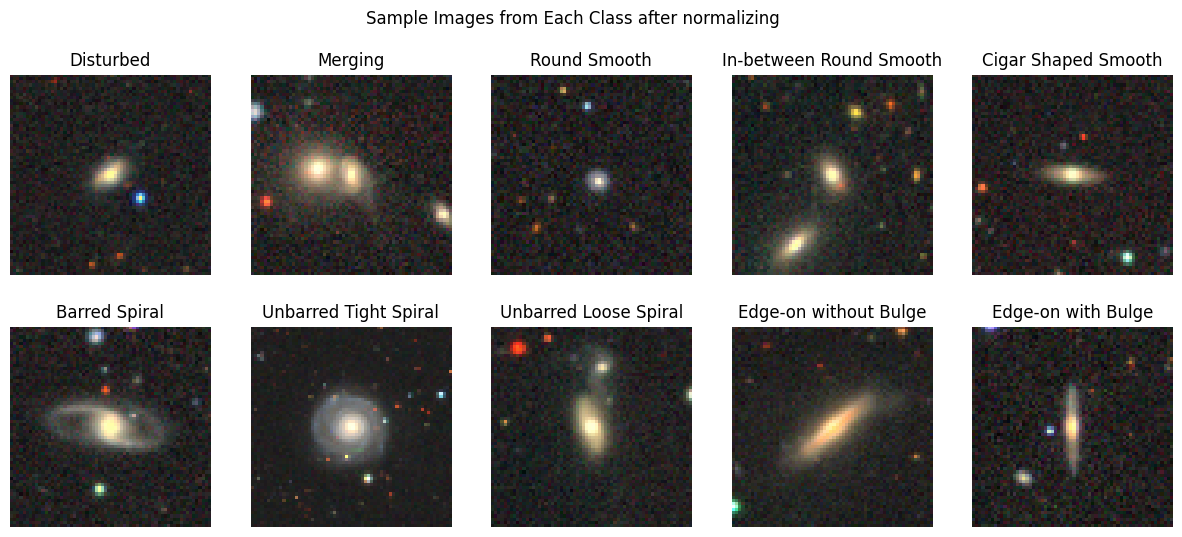

In [ ]:
plt.figure(figsize=(15, 6))# random samples for show
for i in range(10):
    idx = np.random.choice(np.where(labels== i)[0])
    plt.subplot(2, 5, i+1)
    img = images[idx]
    plt.imshow(img, vmin=0, vmax=1)  # ensure proper scaling
    plt.title(class_names[i])
    plt.axis('off')
plt.suptitle('Sample Images from Each Class after normalizing')
plt.show()


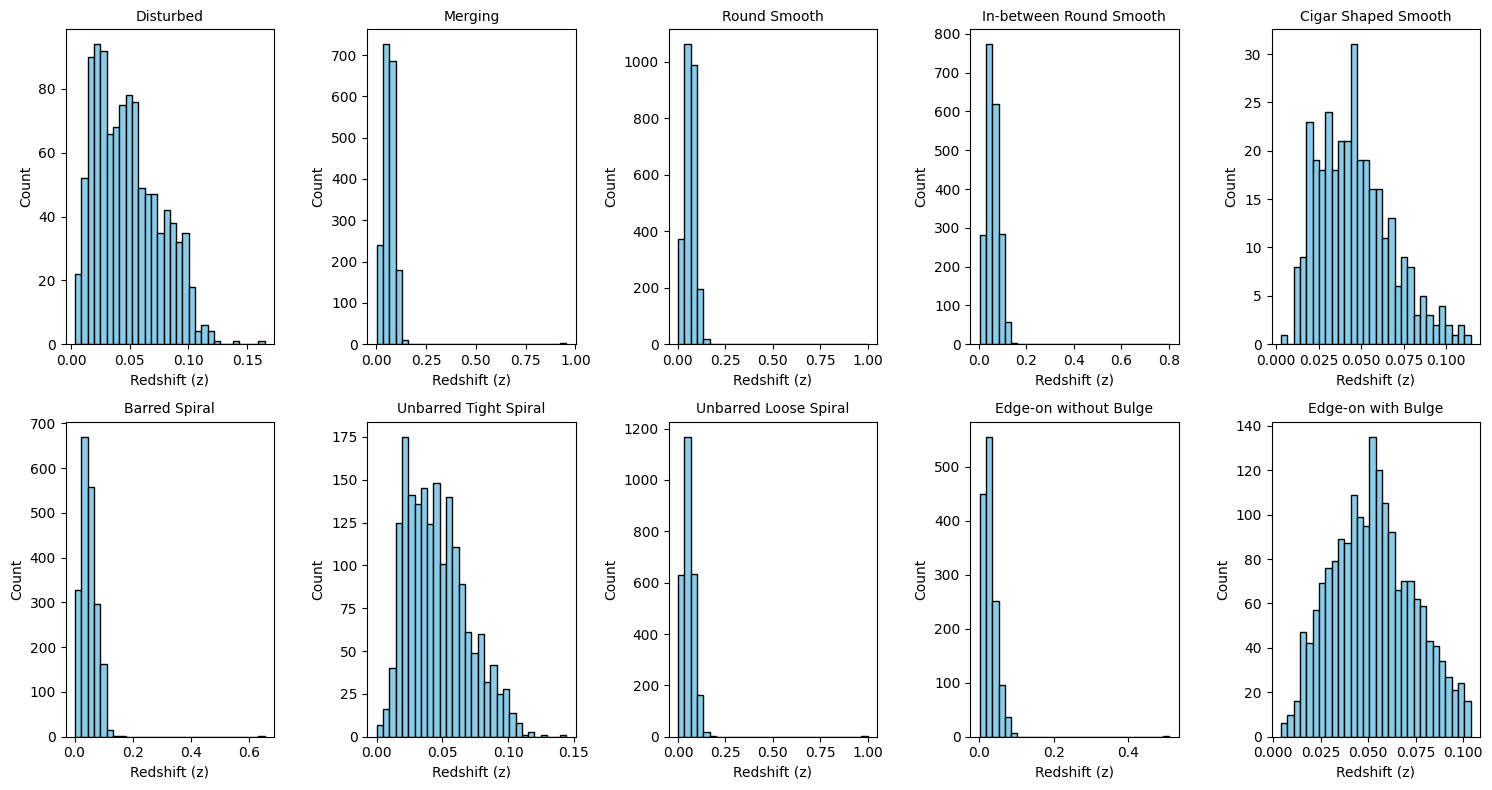

In [ ]:
plt.figure(figsize=(15, 8))
for i, cname in enumerate(class_names):
    plt.subplot(2, 5, i + 1)
    class_z = redshift_norm[labels_clean == i]
    plt.hist(class_z, bins=30, color='skyblue', edgecolor='black')
    plt.title(cname, fontsize=10)
    plt.xlabel("Redshift (z)")
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

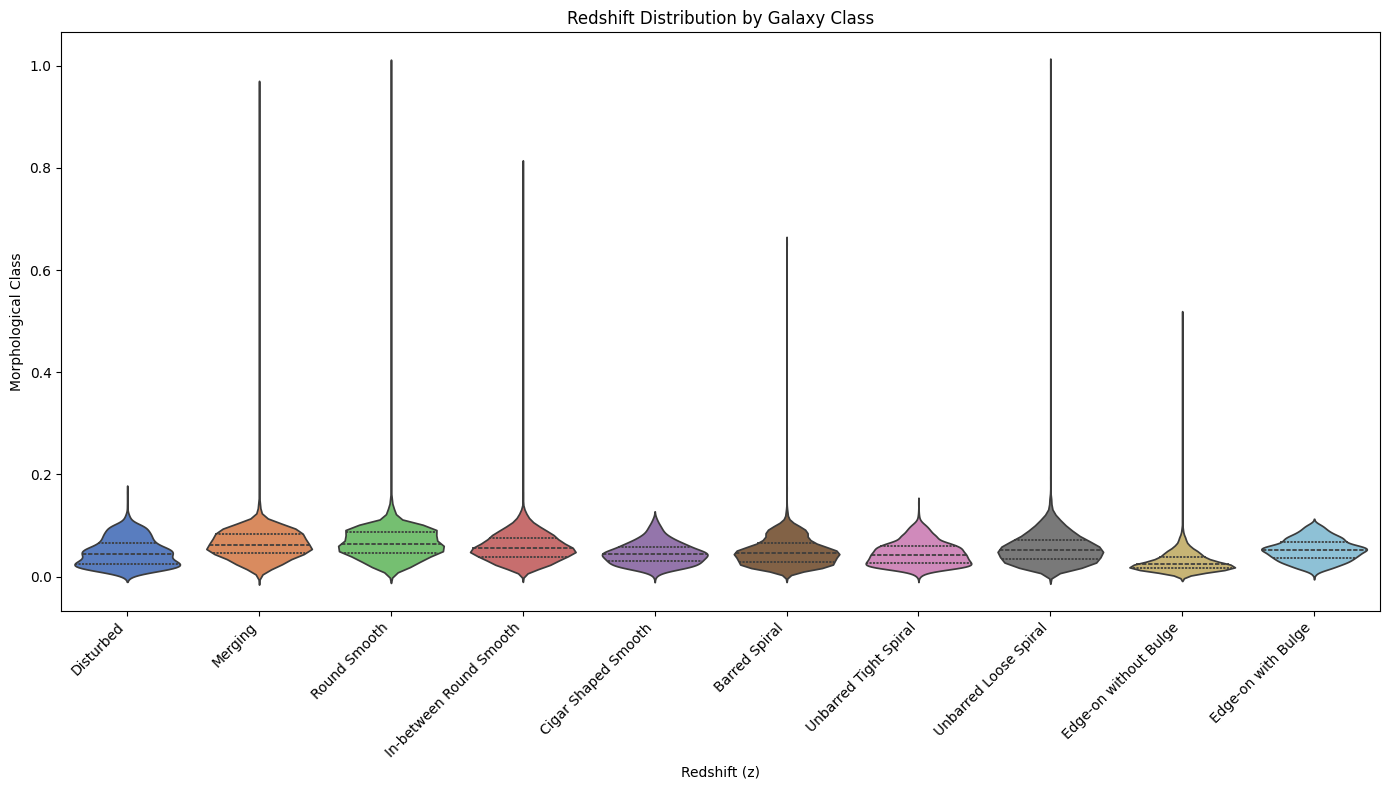

In [ ]:
# Violine Plot for Normalized redshift data
plt.figure(figsize=(14,8))
sns.violinplot(x=x_labels, y=redshift_norm, inner="quart", hue=x_labels, density_norm="width", palette="muted", legend=False)

plt.title("Redshift Distribution by Galaxy Class")
plt.xlabel("Redshift (z)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Morphological Class")
plt.tight_layout()
plt.show()

In [ ]:
# Save preprocessed data
import numpy as np
np.save(f'{data_path}/images_aug.npy', images_4ch)
np.save(f'{data_path}/labels_aug.npy', labels_clean)
np.save(f'{data_path}/redshift_aug.npy', redshift_norm)

print(f"Saved preprocessed data to {data_path}: images_aug.npy, labels_aug.npy, redshift_aug.npy")

Saved preprocessed data to /content/drive/MyDrive/dataset: images_aug.npy, labels_aug.npy, redshift_aug.npy


In [ ]:
#Load preprocessed data( after EDA )
data_path = '/content/drive/MyDrive/dataset'
images_4ch = np.load(f'{data_path}/images_aug.npy')
labels_clean= np.load(f'{data_path}/labels_aug.npy')


class_names = ['Disturbed', 'Merging', 'Round Smooth', 'In-between Round Smooth',
               'Cigar Shaped Smooth', 'Barred Spiral', 'Unbarred Tight Spiral',
               'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']
num_classes = len(class_names)

print(f"Loaded preprocessed data from {data_path}: images.npy, labels.npy, redshit.npy")

Loaded preprocessed data from /content/drive/MyDrive/dataset: images.npy, labels.npy, redshit.npy


In [ ]:
print(type(images_4ch))
print(type(labels_clean))


print(f"Images shape: {images_4ch.shape}, Labels clean shape: {labels_clean.shape}")
print(f"Normalized images min: {images_4ch.min():.4f}, max: {images_4ch.max():.4f}")
print(f"Normalized images mean: {images_4ch.mean():.4f}, std: {images_4ch.std():.4f}")
#print(f"Redshift mean: {np.mean(redshift):.4f}, std: {np.std(redshift):.4f}")
#print(f"Redshift min: {redshift.min():.4f}, max: {redshift.max():.4f}")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Images shape: (17641, 64, 64, 4), Labels clean shape: (17641,)
Normalized images min: 0.0000, max: 1.0000
Normalized images mean: 0.1355, std: 0.1094


In [ ]:
unique_shapes = set(img.shape for img in images_4ch)
print(unique_shapes)


{(64, 64, 4)}


In [ ]:
img0 = images_4ch[0]
print("img0 shape:", img0.shape)

print("slice test:")
print(img0[:, :, 0].shape)
print(img0[:, :, 1].shape)
print(img0[:, :, 2].shape)
print(img0[:, :, 3].shape)


img0 shape: (64, 64, 4)
slice test:
(64, 64)
(64, 64)
(64, 64)
(64, 64)


In [ ]:
# STEP 1: Split into train + (val+test) (70% train, 30% temp)
from sklearn.model_selection import train_test_split
train_idx, tmp_idx = train_test_split(
    np.arange(len(images_4ch)),      # indices
    test_size=0.3,                   # 30% for val+test
    stratify=labels_clean,       # maintain class balance
    random_state=42                  # reproducibility
)

# STEP 2: Split temp into val + test (50/50 → 15% each)
val_idx, test_idx = train_test_split(
    tmp_idx,
    test_size=0.5,                   # 50% of temp → 15% of total
    stratify=labels_clean[tmp_idx],  # maintain balance in val/test
    random_state=42
)

# STEP 3: Verify splits (should be close to class proportions)
print(f"Train size: {len(train_idx)} ({100*len(train_idx)/len(images_4ch):.1f}%)")
print(f"Val size:   {len(val_idx)} ({100*len(val_idx)/len(images_4ch):.1f}%)")
print(f"Test size:  {len(test_idx)} ({100*len(test_idx)/len(images_4ch):.1f}%)")
print(f"Total: {len(train_idx) + len(val_idx) + len(test_idx)} (should be {len(images_4ch)})")


Train size: 12348 (70.0%)
Val size:   2646 (15.0%)
Test size:  2647 (15.0%)
Total: 17641 (should be 17641)


In [ ]:
# STEP 1: Count classes in each split
# 2. Identify minority classes in TRAINING set only
from collections import Counter

# STEP 1: Count classes in the TRAIN split ONLY
train_images = images_4ch[train_idx]
train_labels = labels_clean[train_idx]

val_images = images_4ch[val_idx]
val_labels = labels_clean[val_idx]

test_images = images_4ch[test_idx]
test_labels = labels_clean[test_idx]


# STEP 2: Count class frequencies
class_counts = Counter(train_labels)
print("Class counts in training:", class_counts)


# STEP 3: Target count = largest class
target_count = max(class_counts.values())
print(f"\nTarget count (largest class): {target_count}")


# STEP 4: Print class counts clearly
print("\nTraining set class counts:")
for c in sorted(class_counts.keys()):
    print(f"Class {c}: {class_counts[c]} images")

# STEP 5: Total train images
print("\nTotal training images:", len(train_labels))


Class counts in training: Counter({np.uint8(2): 1848, np.uint8(7): 1830, np.uint8(5): 1423, np.uint8(3): 1414, np.uint8(9): 1306, np.uint8(1): 1290, np.uint8(6): 1276, np.uint8(8): 977, np.uint8(0): 751, np.uint8(4): 233})

Target count (largest class): 1848

Training set class counts:
Class 0: 751 images
Class 1: 1290 images
Class 2: 1848 images
Class 3: 1414 images
Class 4: 233 images
Class 5: 1423 images
Class 6: 1276 images
Class 7: 1830 images
Class 8: 977 images
Class 9: 1306 images

Total training images: 12348


In [ ]:
# 2. Augmentation function (4-channel safe)
# Preprocessing layers for rotation and translation
random_rotation = tf.keras.layers.RandomRotation(
    factor=0.10,     # ~ ±18 degrees
    fill_mode="reflect"
)

random_translation = tf.keras.layers.RandomTranslation(
    height_factor=0.05,   # ±5% (≈ ±3 pixels)
    width_factor=0.05,
    fill_mode="reflect"
)


def augment_fn(image_4ch, label):
    img = tf.cast(image_4ch, tf.float32)

    #1.Separate RGB and redshift(split RGB and Redshift)
    rgb = img[:, :, :3] #(64,64,3)
    z_map = img[:, :, 3:] #(64,64,1)
    # 2.Geometric: flip (applied to only on grb channels)
    rgb = tf.image.random_flip_left_right(rgb)
    rgb = tf.image.random_flip_up_down(rgb)

    # Rotation (±18 degrees)
    rgb = random_rotation(rgb, training=True)

    # Translation (±5%)
    rgb = random_translation(rgb, training=True)

    #3.Photometric: ONLY on RGB
    rgb = tf.image.random_brightness(rgb, max_delta=0.1)
    rgb = tf.image.random_contrast(rgb, lower=0.9, upper=1.1)
    rgb = tf.image.random_saturation(rgb, lower=0.9, upper=1.1)
    # Small sensor noise (CCD / photon noise)
    # Apply Gaussian background noise
    def add_background_noise(rgb):
        noise = tf.random.normal(tf.shape(rgb), mean=0.0, stddev=0.01)
        return tf.clip_by_value(rgb + noise, 0.0, 1.0)

    rgb = tf.cond(
        tf.random.uniform([]) < 0.40,   # 40% chance
        lambda: add_background_noise(rgb),
        lambda: rgb
    )
    #  Added smooth gradient background
    def add_background_gradient(rgb):
        x = tf.linspace(0.0, 1.0, 64)
        y = tf.linspace(0.0, 1.0, 64)
        X, Y = tf.meshgrid(x, y)

        strength = tf.random.uniform([], 0.01, 0.05)
        angle = tf.random.uniform([], 0.0, 6.28318)  # 0–2π

        grad = strength * (X * tf.cos(angle) + Y * tf.sin(angle))
        grad = grad[..., tf.newaxis]   # (64,64,1) -> broadcast automatically

        return tf.clip_by_value(rgb + grad, 0.0, 1.0)

    rgb = tf.cond(
        tf.random.uniform([]) < 0.25,   # 25% chance
        lambda: add_background_gradient(rgb),
        lambda: rgb
    )
    # FINAL SAFE CLIP (important)
    rgb = tf.clip_by_value(rgb, 0.0, 1.0)

    # REDSHIFT AUGMENTATION (TINY, PHYSICALLY SAFE)
    def add_redshift_noise(z_map):
        noise = tf.random.normal(tf.shape(z_map), mean=0.0, stddev=0.002) # Corrected variable from 'z' to 'z_map'
        return tf.clip_by_value(z_map + noise, 0.0, 1.0)

    # 50% chance of tiny noise
    z_map= tf.cond(
        tf.random.uniform([]) < 0.50,
        lambda: add_redshift_noise(z_map),
        lambda: z_map
    )


    # Re-stack
    img = tf.concat([rgb, z_map], axis=-1)
    return img, label

In [ ]:
import numpy as np
from collections import Counter
# Step 3 — Build balanced per-class datasets
AUTOTUNE = tf.data.AUTOTUNE
class_datasets = []

for cls in sorted(class_counts.keys()):
    # Find indices for this class
    cls_idx = np.where(train_labels == cls)[0]

    # Extract the corresponding images and labels
    cls_imgs = train_images[cls_idx]     # **using train_images ONLY**
    cls_labs = train_labels[cls_idx]
    print(f"Class {cls}: {len(cls_idx)} → {target_count}")
    # Convert to tf.data
    cls_ds = tf.data.Dataset.from_tensor_slices((cls_imgs, cls_labs))

    # 2) Shuffle (important for repeat)
    cls_ds = cls_ds.shuffle(len(cls_idx), reshuffle_each_iteration=True)
    # Repeat BEFORE augmentation( new change)
    cls_ds = cls_ds.repeat()

    # 2) Augmentation BEFORE oversampling
    cls_ds = cls_ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
    # Hard LIMIT to 1848 per class( new change)
    cls_ds = cls_ds.take(target_count)
    class_datasets.append(cls_ds)
print("\nClass datasets created:", len(class_datasets))
    # # 3) Oversample small classes
    # if len(cls_idx) < target_count:
    #     cls_ds = cls_ds.repeat().take(target_count)
    #     print(f"Class {cls}: {len(cls_idx)} → {target_count} (oversampled)")
    # else:
    #     cls_ds = cls_ds.take(target_count)
    #     print(f"Class {cls}: {len(cls_idx)} → {target_count} (trimmed)")

    # class_datasets.append(cls_ds)

# Combine to Balanced Training Dataset
balanced_train_ds = tf.data.Dataset.sample_from_datasets(
    class_datasets,
    weights=[1/10] * 10,
    seed=42,
)



print("Balanced training dataset:", balanced_train_ds)
print("Datasets count:", len(class_datasets))

Class 0: 751 → 1848
Class 1: 1290 → 1848
Class 2: 1848 → 1848
Class 3: 1414 → 1848
Class 4: 233 → 1848
Class 5: 1423 → 1848
Class 6: 1276 → 1848
Class 7: 1830 → 1848
Class 8: 977 → 1848
Class 9: 1306 → 1848

Class datasets created: 10
Balanced training dataset: <_DirectedInterleaveDataset element_spec=(TensorSpec(shape=(64, 64, 4), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
Datasets count: 10


In [ ]:
# Build train_ds
BATCH_SIZE = 64

# 5) Final batching
train_ds = (
    balanced_train_ds
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

#Validation/Test (no augmentation, no oversampling)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(BATCH_SIZE)


In [ ]:

# # Plot Original vs Augmented Redshift

# # Step 1: Pick 1 representative image per class
# class_examples = {}  # {class_id: image}

# for img, lab in zip(train_images, train_labels):
#     lab = int(lab)
#     if lab not in class_examples:
#         class_examples[lab] = img   # store 64×64×4
#     if len(class_examples) == 10:
#         break

# print("Collected classes:", class_examples.keys())


# #Step 2: Augment once per class for comparison
# aug_examples = {}

# for lab, img in class_examples.items():
#     aug_img, _ = augment_fn(tf.constant(img), tf.constant(lab))
#     aug_examples[lab] = aug_img.numpy()


# # Step 3: Plot Original vs Augmented Redshift
# plt.figure(figsize=(10, 40))

# for idx, lab in enumerate(sorted(class_examples.keys())):

#     orig = class_examples[lab][:, :, 3]           # (64,64) original redshift
#     aug = aug_examples[lab][:, :, 3]              # augmented redshift

#     # Plot original z-map
#     plt.subplot(10, 2, 2*idx + 1)
#     plt.imshow(orig, cmap="magma")
#     plt.colorbar()
#     plt.title(f"Original Redshift — Class {lab}")
#     plt.axis("off")

#     # Plot augmented z-map
#     plt.subplot(10, 2, 2*idx + 2)
#     plt.imshow(aug, cmap="magma")
#     plt.colorbar()
#     plt.title(f"Augmented Redshift — Class {lab}")
#     plt.axis("off")


# plt.tight_layout()
# plt.show()


Collected classes: dict_keys([3, 6, 7, 0, 2, 5, 1, 9, 8, 4])


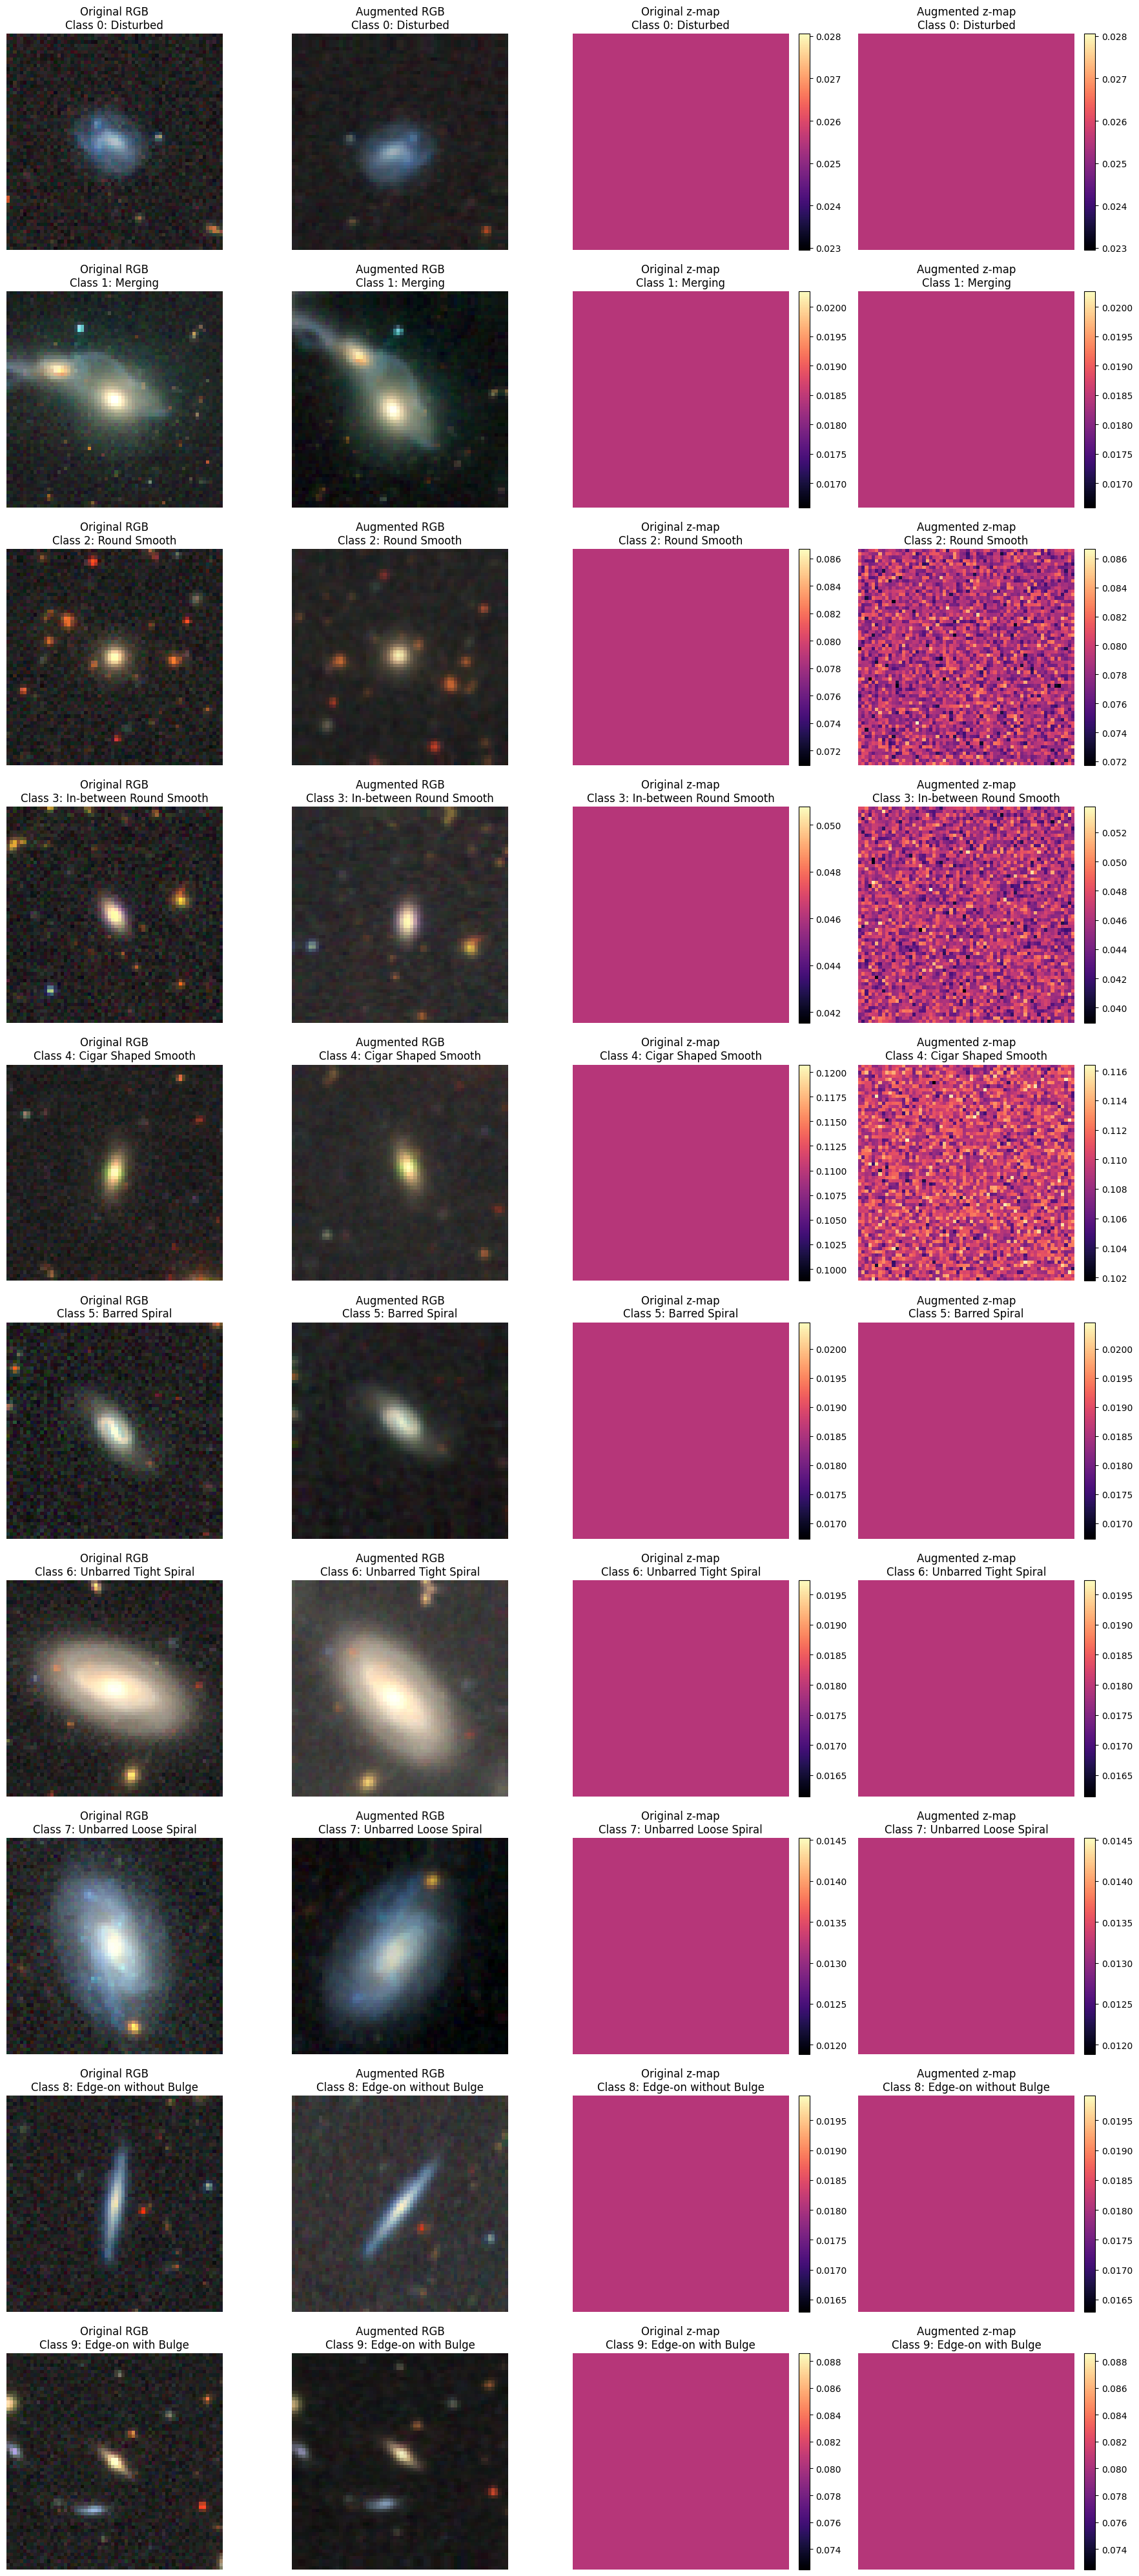

In [ ]:
# QUALITATIVE CHECK
'''ORIGINAL vs AUGMENTED (RGB + Redshift) — Per Class (10 classes)
'''
# Step 1: Pick 1 representative image per class
class_examples = {}  # {class_id: image}

for img, lab in zip(train_images, train_labels):
    lab = int(lab)
    if lab not in class_examples:
        class_examples[lab] = img
    if len(class_examples) == num_classes:
        break

print("Collected classes:", class_examples.keys())


# --- Step 2: Augment once per class ---
aug_examples = {}

for lab, img in class_examples.items():
    aug_img, _ = augment_fn(tf.constant(img), tf.constant(lab))
    aug_examples[lab] = aug_img.numpy()


# --- Step 3: Plot (10 rows × 4 columns) ---
plt.figure(figsize=(18, 40))

for idx, lab in enumerate(sorted(class_examples.keys())):

    orig = class_examples[lab]
    aug  = aug_examples[lab]

    orig_rgb = orig[:, :, :3]
    orig_z   = orig[:, :, 3]

    aug_rgb = aug[:, :, :3]
    aug_z   = aug[:, :, 3]

    class_name = class_names[lab]

    # Column 1 — Original RGB
    plt.subplot(10, 4, 4*idx + 1)
    plt.imshow(orig_rgb)
    plt.title(f"Original RGB\nClass {lab}: {class_name}")
    plt.axis("off")

    # Column 2 — Augmented RGB
    plt.subplot(10, 4, 4*idx + 2)
    plt.imshow(aug_rgb)
    plt.title(f"Augmented RGB\nClass {lab}: {class_name}")
    plt.axis("off")

    # Column 3 — Original Redshift Map
    plt.subplot(10, 4, 4*idx + 3)
    plt.imshow(orig_z, cmap="magma")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f"Original z-map\nClass {lab}: {class_name}")
    plt.axis("off")

    # Column 4 — Augmented Redshift Map
    plt.subplot(10, 4, 4*idx + 4)
    plt.imshow(aug_z, cmap="magma")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f"Augmented z-map\nClass {lab}: {class_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()


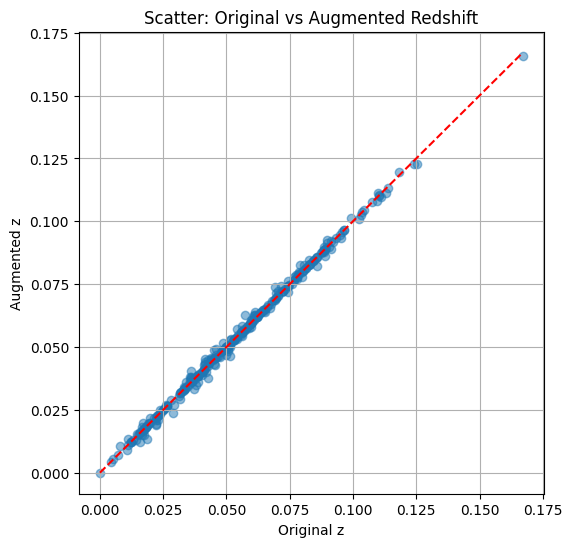

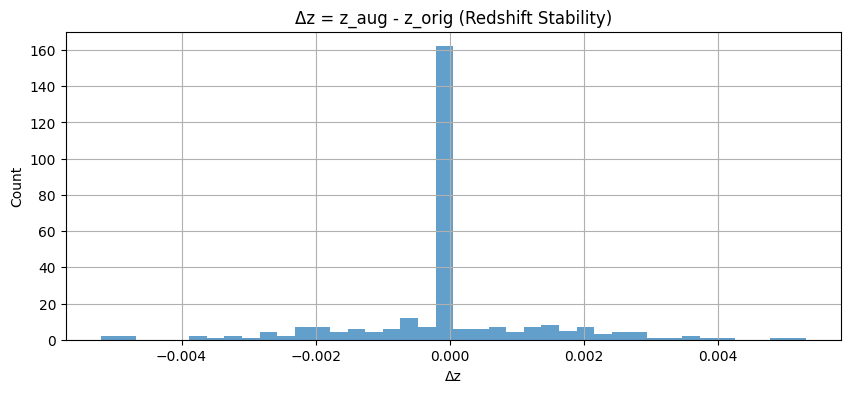

In [ ]:
# TEST 3 — Δz STABILITY (Augmented vs Original)
'''Scatter Plot + Δz Histogram + Per-Class Boxplots
'''
# Step 1: Collect original & augmented z for SAME images
n = 300   # number of samples to compare
orig_sample = train_images[:n]

orig_values = np.array([img[0,0,3] for img in orig_sample])
aug_values  = []

for img in orig_sample:
    aug_img, _ = augment_fn(tf.constant(img), tf.constant(0))
    aug_values.append(float(aug_img.numpy()[0,0,3]))

aug_values = np.array(aug_values)


# Step 2: Compute Δz
dz = aug_values - orig_values


# Step 3: SCATTER: z_orig vs z_aug
plt.figure(figsize=(6,6))
plt.scatter(orig_values, aug_values, alpha=0.5)
plt.plot([orig_values.min(), orig_values.max()],
         [orig_values.min(), orig_values.max()], 'r--')
plt.xlabel("Original z")
plt.ylabel("Augmented z")
plt.title("Scatter: Original vs Augmented Redshift")
plt.grid(True)
plt.show()


#Step 4: Δz HISTOGRAM
plt.figure(figsize=(10,4))
plt.hist(dz, bins=40, alpha=0.7)
plt.title("Δz = z_aug - z_orig (Redshift Stability)")
plt.xlabel("Δz")
plt.ylabel("Count")
plt.grid(True)
plt.show()


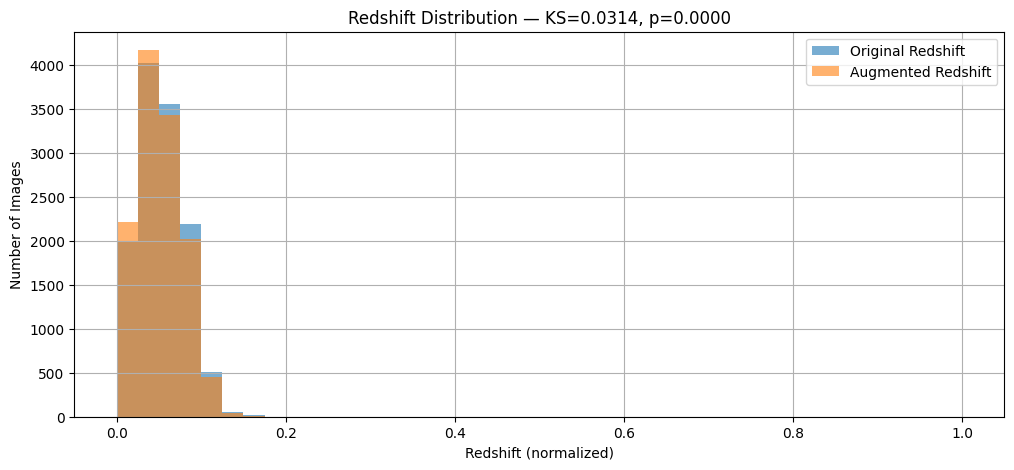

In [ ]:
# Test3: Redshift Distribution (Before vs After) + KS Test
# 1 — ORIGINAL redshift (each image has 1 redshift value)
from scipy.stats import ks_2samp
orig_z_values = np.array([img[0,0,3] for img in train_images])


# 2 — AUGMENTED redshift (collect 3000 samples)
aug_z_values = []

for img, _ in train_ds.unbatch().take(len(orig_z_values)):
    z_map = img.numpy()[:,:,3]     # (64,64)
    aug_z_values.append(z_map[0,0])   # or z_map.mean()

aug_z_values = np.array(aug_z_values)

# Step 3: KS Test
ks_stat, ks_p = ks_2samp(orig_z_values, aug_z_values)
# 4: hist plot with KDe
plt.figure(figsize=(12,5))
plt.hist(orig_z_values, bins=40, alpha=0.6, label='Original Redshift')
plt.hist(aug_z_values, bins=40, alpha=0.6, label='Augmented Redshift')
plt.xlabel("Redshift (normalized)")
plt.ylabel("Number of Images")
plt.title(f"Redshift Distribution — KS={ks_stat:.4f}, p={ks_p:.4f}")
# plt.title("Original vs Augmented Redshift Distribution")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# # Plot original vs augmented(optional plot)
# #  Extract train images and labels from train data numpy arrays
# train_images = images_4ch[train_idx]     # shape (N, 64, 64, 4)
# train_labels = labels_clean[train_idx]   # shape (N,)

# num_classes = len(class_names)


# #  STEP 1 — ORIGINAL vs AUGMENTED (1 sample per class)
# class_examples = {}   # {class_id: image}

# for img, lab in zip(train_images, train_labels):
#     lab = int(lab)
#     if lab not in class_examples:
#         class_examples[lab] = img        # store 64×64×4 image
#     if len(class_examples) == num_classes:
#         break

# print("Collected class examples:", class_examples.keys())


# # Apply augmentation manually for each class image
# augmented_examples = {}

# for lab, img in class_examples.items():
#     aug_img, _ = augment_fn(
#         tf.constant(img),              # original image
#         tf.constant(lab)               # label
#     )
#     augmented_examples[lab] = aug_img.numpy()


# #  Plot original vs augmented, one row per class
# plt.figure(figsize=(12, 30))

# for idx, lab in enumerate(sorted(class_examples.keys())):

#     # ORIGINAL RGB
#     plt.subplot(num_classes, 2, 2*idx + 1)
#     plt.imshow(class_examples[lab][:, :, :3])  # only RGB channels
#     plt.title(f"Original — Class {lab} ({class_names[lab]})")
#     plt.axis("off")

#     # AUGMENTED RGB (clipped for display)
#     aug_rgb = tf.clip_by_value(
#         augmented_examples[lab][:, :, :3], 0, 1
#     ).numpy()
#     plt.subplot(num_classes, 2, 2*idx + 2)
#     plt.imshow(aug_rgb)
#     plt.title(f"Augmented — Class {lab} ({class_names[lab]})")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

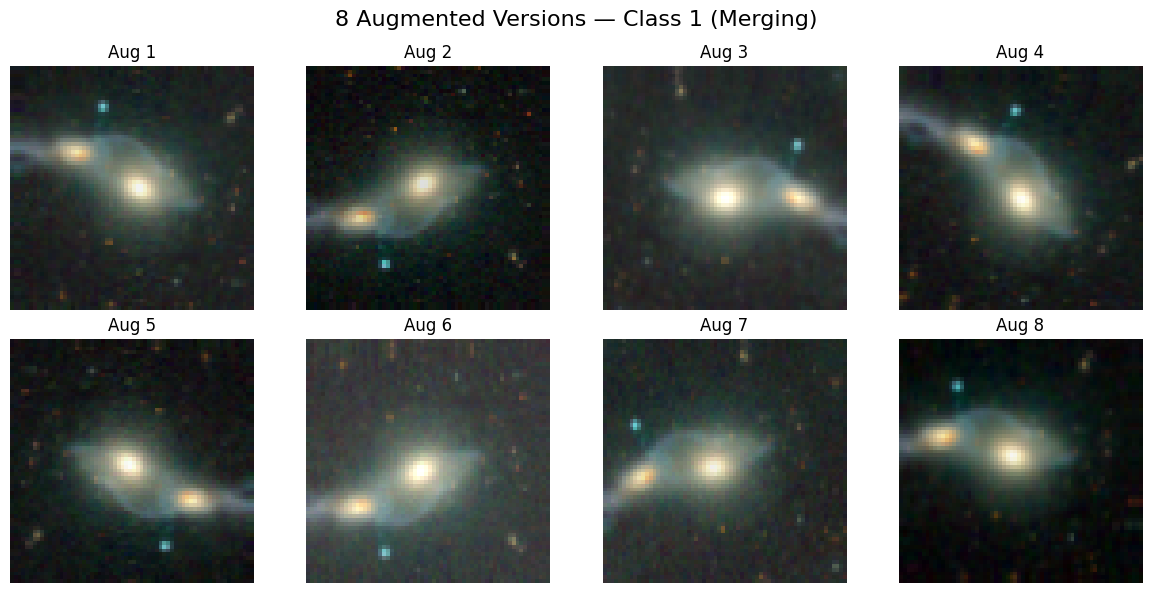

In [ ]:
# PLOT :8 Augmentations of One Image
sample_lab = 1
sample_img = class_examples[sample_lab]

plt.figure(figsize=(12, 6))
for i in range(8):
    aug_img, _ = augment_fn(tf.constant(sample_img), tf.constant(sample_lab))
    aug_rgb = np.clip(aug_img.numpy()[:,:,:3], 0, 1)

    plt.subplot(2, 4, i+1)
    plt.imshow(aug_rgb)
    plt.title(f"Aug {i+1}")
    plt.axis("off")

plt.suptitle(f"8 Augmented Versions — Class {sample_lab} ({class_names[sample_lab]})", fontsize=16)
plt.tight_layout()
plt.show()


Random sample index: 3040, class = 5

 PIXEL STATISTICS (RGB only)
Original: mean = 0.1655
Augmented: mean = 0.1447
Difference (aug - orig) = -0.0208

Augmented RGB min  : 0.0282
Augmented RGB max  : 1.0000
Augmented RGB std  : 0.1264


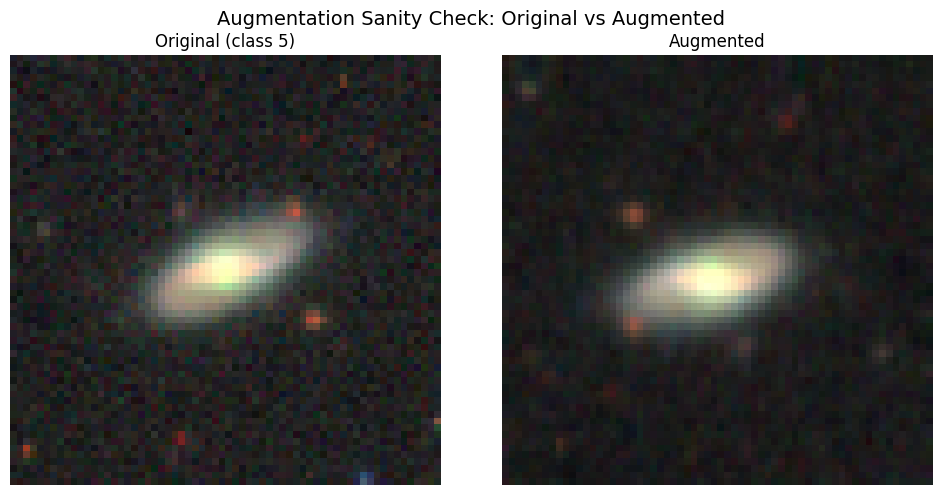

In [ ]:
# Augmentation Sanity Check: Original vs Augmented

# 1) Pick a random training image
idx = np.random.randint(len(train_images))
orig_img = train_images[idx]
orig_label = train_labels[idx]

print(f"Random sample index: {idx}, class = {orig_label}")

# 2) Apply augmentation ONCE
aug_img, _ = augment_fn(tf.constant(orig_img), tf.constant(orig_label))
aug_img = aug_img.numpy()

# 3) Compute stats (RGB only)
orig_rgb = orig_img[..., :3].astype("float32")
aug_rgb  = aug_img[..., :3].astype("float32")

orig_mean = orig_rgb.mean()
aug_mean  = aug_rgb.mean()
diff_mean = aug_mean - orig_mean

print("\n PIXEL STATISTICS (RGB only)")
print(f"Original: mean = {orig_mean:.4f}")
print(f"Augmented: mean = {aug_mean:.4f}")
print(f"Difference (aug - orig) = {diff_mean:.4f}")

print(f"\nAugmented RGB min  : {aug_rgb.min():.4f}")
print(f"Augmented RGB max  : {aug_rgb.max():.4f}")
print(f"Augmented RGB std  : {aug_rgb.std():.4f}")

# 4) Plot original vs augmented
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(np.clip(orig_rgb, 0, 1))
plt.title(f"Original (class {orig_label})")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(np.clip(aug_rgb, 0, 1))
plt.title("Augmented")
plt.axis("off")

plt.suptitle("Augmentation Sanity Check: Original vs Augmented", fontsize=14)
plt.tight_layout()
plt.show()


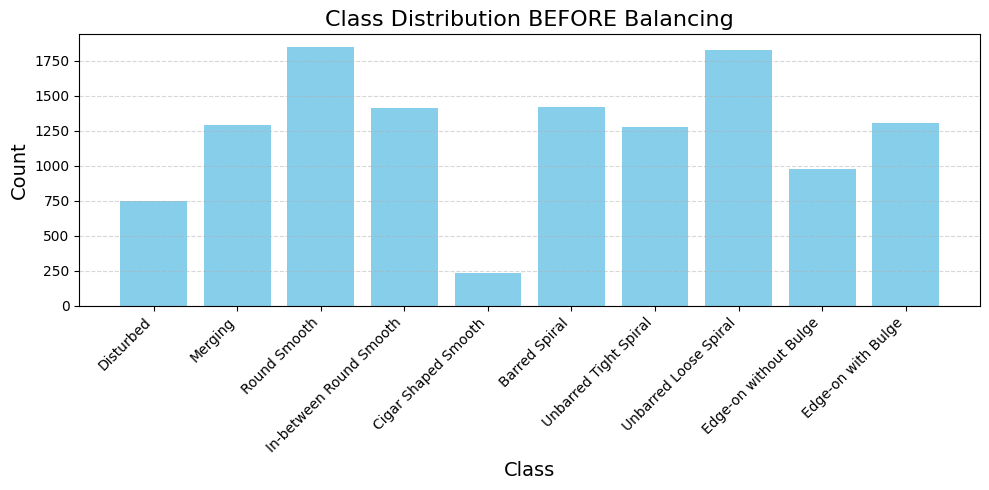

In [ ]:
# PLOT 1 — Class Distribution BEFORE Balancing
from collections import Counter
counts_before = Counter(train_labels)
plt.figure(figsize=(10,5))
plt.bar(range(10), [counts_before[i] for i in range(10)], color='skyblue')
plt.title("Class Distribution BEFORE Balancing", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Class distribution AFTER augmentation:
Counter({7: 1848, 8: 1848, 5: 1848, 4: 1848, 9: 1848, 2: 1848, 1: 1848, 0: 1848, 6: 1848, 3: 1848})


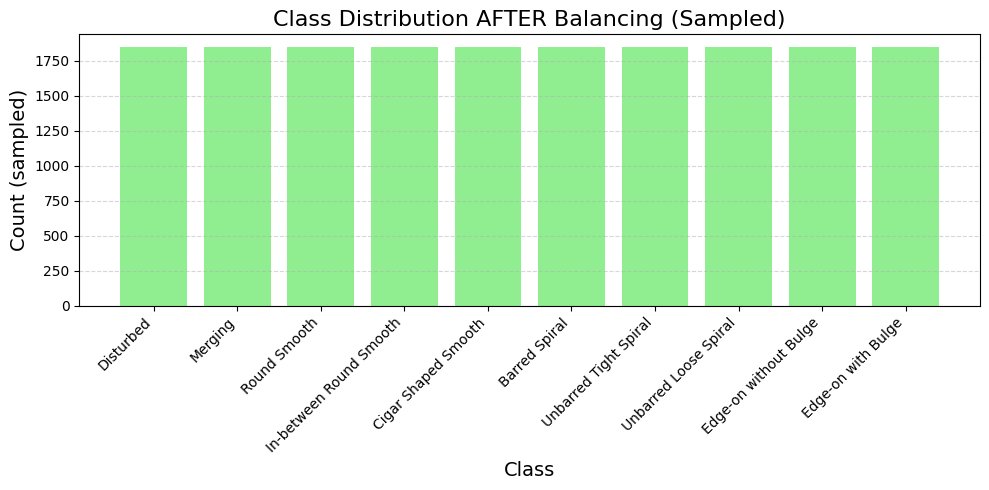

Balanced Counts:
Class 0: 1848 (expected ~1848)
Class 1: 1848 (expected ~1848)
Class 2: 1848 (expected ~1848)
Class 3: 1848 (expected ~1848)
Class 4: 1848 (expected ~1848)
Class 5: 1848 (expected ~1848)
Class 6: 1848 (expected ~1848)
Class 7: 1848 (expected ~1848)
Class 8: 1848 (expected ~1848)
Class 9: 1848 (expected ~1848)


In [ ]:
# PLOT 2 — Class Distribution AFTER Balancing
counts_after = Counter()

# sample EXACT=N samples from the balanced dataset
for _, lab in train_ds.unbatch():
    counts_after[int(lab.numpy())] += 1
print("Class distribution AFTER augmentation:")
print(counts_after)

plt.figure(figsize=(10,5))
plt.bar(range(10), [counts_after[i] for i in range(10)], color='lightgreen')
plt.title("Class Distribution AFTER Balancing (Sampled)", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Count (sampled)", fontsize=14)
plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Balanced Counts:")
for i in range(10):
    print(f"Class {i}: {counts_after[i]} (expected ~1848)")

Class distribution AFTER augmentation:
Counter({7: 1848, 8: 1848, 5: 1848, 4: 1848, 9: 1848, 2: 1848, 1: 1848, 0: 1848, 6: 1848, 3: 1848})


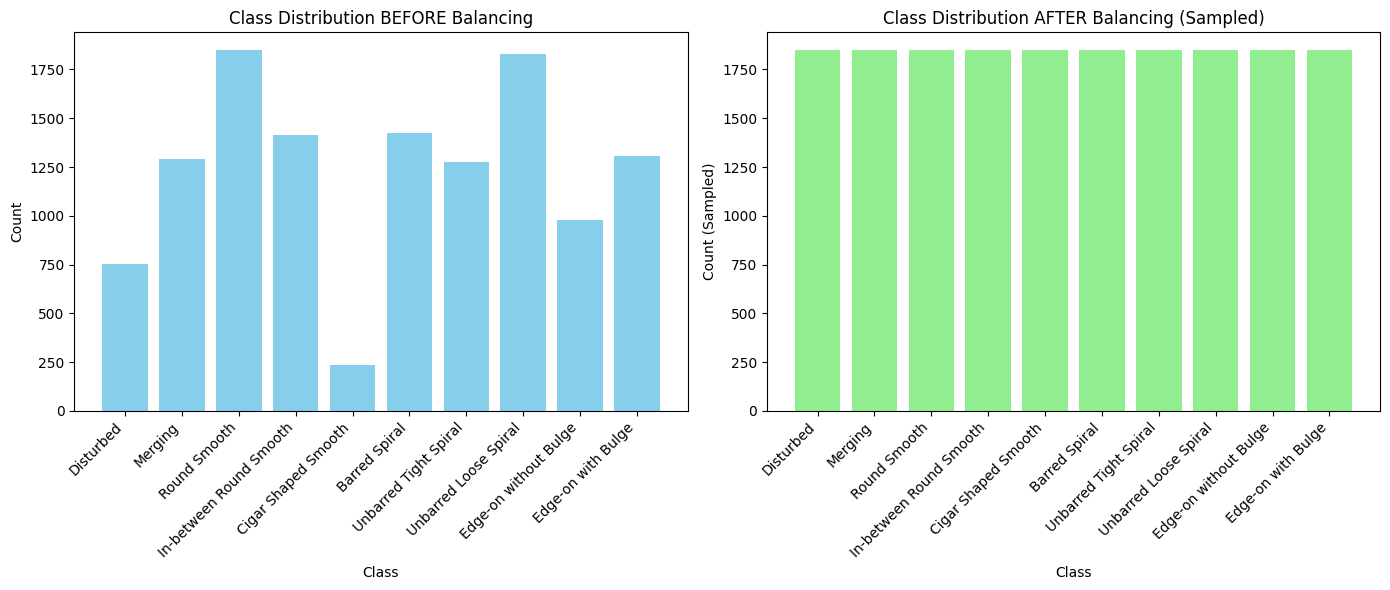

In [ ]:
# optional figure

# --- BEFORE ---
counts_before = Counter(train_labels)
# after augmentation
counts_after_aug = Counter()

# unbatch gives individual samples (not batches)
for _, lab in train_ds.unbatch():
    counts_after_aug[int(lab.numpy())] += 1

print("Class distribution AFTER augmentation:")
print(counts_after_aug)

plt.figure(figsize=(14,6))

# BEFORE plot
plt.subplot(1,2,1)
plt.bar(range(10), [counts_before[i] for i in range(10)], color='skyblue')
plt.title("Class Distribution BEFORE Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(10), class_names, rotation=45, ha='right')
# AFTER plot
plt.subplot(1,2,2)
plt.bar(range(10), [counts_after_aug[i] for i in range(10)], color='lightgreen')
plt.title("Class Distribution AFTER Balancing (Sampled)")
plt.xlabel("Class")
plt.ylabel("Count (Sampled)")
plt.xticks(range(10), class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()



In [ ]:
# # Check 100 augmented samples - correctly!
# value_checker = train_ds.take(10)

# rgb_mins, rgb_maxs = [], []
# z_mins, z_maxs = [], []

# for img_batch, _ in value_checker.batch(32):
#     img_batch = tf.clip_by_value(img_batch, 0.0, 1.0)  # safety

#     # RGB channels
#     rgb = img_batch[:, :, :, :3]
#     rgb_mins.append(tf.reduce_min(rgb).numpy())
#     rgb_maxs.append(tf.reduce_max(rgb).numpy())

#     # Redshift channel (constant per image)
#     z = img_batch[:, :, :, 3]
#     z_mins.append(tf.reduce_min(z).numpy())
#     z_maxs.append(tf.reduce_max(z).numpy())

# print(f"RGB Range: [{min(rgb_mins):.3f}, {max(rgb_maxs):.3f}] (should be [0, 1])")
# print(f"Redshift Range: [{min(z_mins):.3f}, {max(z_maxs):.3f}] (dataset raw normalized range)")
# # Plot distributions
# fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# axes[0].hist(rgb_mins, alpha=0.5, label='RGB min')
# axes[0].hist(rgb_maxs, alpha=0.5, label='RGB max')
# axes[0].set_title("RGB Channel Value Distribution")
# axes[0].legend()
# axes[1].hist(z_mins, alpha=0.5, label='Redshift min')
# axes[1].hist(z_maxs, alpha=0.5, label='Redshift max')
# axes[1].set_title("Redshift Channel Value Distribution")
# axes[1].legend()
# plt.show()

In [ ]:
# 3. Apply augmentation, batch, prefetch
import math
target_count = max(class_counts.values())   # e.g., 1848
num_classes = len(class_counts)

STEPS_PER_EPOCH = math.ceil((target_count * num_classes) / BATCH_SIZE)

print(STEPS_PER_EPOCH)


289


In [ ]:
from tensorflow.keras import layers, models

def build_galaxynet_cnn_mc(input_shape=(64,64,4), n_class=10, dropout_p=0.3):

    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(dropout_p)(x, training=True)

    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(dropout_p)(x, training=True)

    # Block 2
    x = layers.Conv2D(64, 3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(dropout_p)(x, training=True)

    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(dropout_p)(x, training=True)

    # Block 3
    x = layers.Conv2D(128, 3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(dropout_p)(x, training=True)

    x = layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(dropout_p)(x, training=True)

    # Block 4
    x = layers.Conv2D(256, 3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(dropout_p)(x, training=True)

    x = layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(dropout_p)(x, training=True)

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_p)(x, training=True)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_p)(x, training=True)

    logits = layers.Dense(n_class)(x)

    return models.Model(inputs, logits, name="GalaxyNet_CNN_MC")


In [ ]:
# Build Model A (dropout_p=0.3 for regularization)
model_a = build_galaxynet_cnn_mc(input_shape=(64,64,4), n_class=10)

# Compile (monitor macro-F1 for minority classes)
model_a.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model_a.summary()

Model: "GalaxyNet_CNN_MC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 64, 64, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 64, 64, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 32, 32, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 32, 32, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,275,402 (4.87 MB)

 Trainable params: 1,273,482 (4.86 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Callbacks
callbacks = [
    # Early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        min_delta = 1e-4,
        mode ='min',
        restore_best_weights=True,
        verbose=1
    ),

    # Learning rate reduction
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    # Model checkpoint
    tf.keras.callbacks.ModelCheckpoint(
        'models/mc_dropout_best.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )]

In [ ]:
# Training
history = model_a.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100, # we can use more epoch next day
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=callbacks,
    verbose = 1
)

Epoch 1/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.1347 - loss: 2.2662
Epoch 1: val_accuracy improved from -inf to 0.10128, saving model to models/mc_dropout_best.keras
289/289 ━━━━━━━━━━━━━━━━━━━━ 72s 172ms/step - accuracy: 0.1347 - loss: 2.2660 - val_accuracy: 0.1013 - val_loss: 2.5431 - learning_rate: 0.0010
Epoch 2/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.1704 - loss: 2.1742
Epoch 2: val_accuracy improved from 0.10128 to 0.24603, saving model to models/mc_dropout_best.keras
289/289 ━━━━━━━━━━━━━━━━━━━━ 45s 157ms/step - accuracy: 0.1704 - loss: 2.1742 - val_accuracy: 0.2460 - val_loss: 2.0153 - learning_rate: 0.0010
Epoch 3/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.1919 - loss: 2.1242
Epoch 3: val_accuracy did not improve from 0.24603
289/289 ━━━━━━━━━━━━━━━━━━━━ 46s 158ms/step - accuracy: 0.1919 - loss: 2.1241 - val_accuracy: 0.2453 - val_loss: 1.9638 - learning_rate: 0.0010
Epoch 4/100
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/s

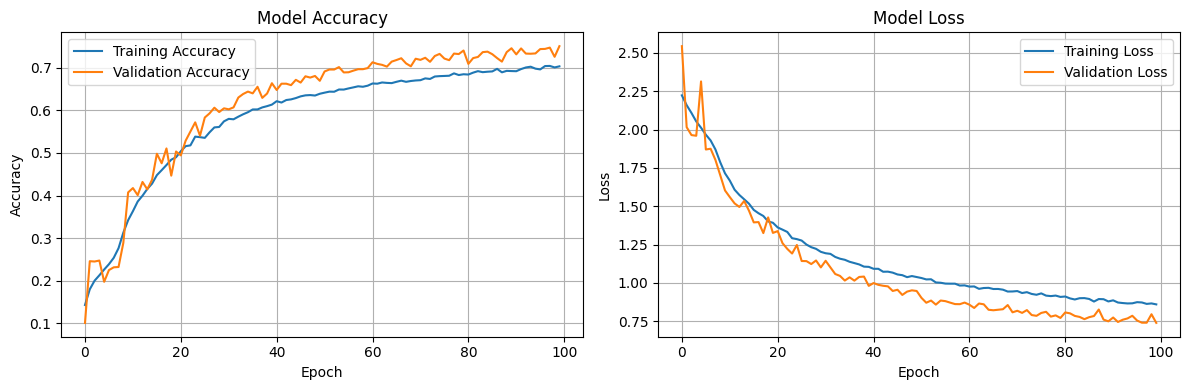

In [ ]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [ ]:
# import numpy as np

# def evaluate_deterministic(model, test_ds):
#     all_preds = []
#     all_labels = []

#     for imgs, labels in test_ds:
#         # Disable dropout: training=False
#         logits = model(imgs, training=False)
#         preds = tf.nn.softmax(logits, axis=-1)

#         all_preds.append(preds.numpy())
#         all_labels.append(labels.numpy())

#     all_preds = np.concatenate(all_preds, axis=0)
#     all_labels = np.concatenate(all_labels, axis=0)

#     # Compute acc manually
#     y_pred = np.argmax(all_preds, axis=1)
#     accuracy = np.mean(y_pred == all_labels)

#     # Compute cross-entropy loss
#     loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
#     loss = loss_fn(all_labels, all_preds).numpy()

#     return loss, accuracy


In [ ]:
# Classical Evaluation (Non-Bayesian)
# Standard test evaluation
test_loss, test_acc = model_a.evaluate(test_ds, verbose=1)

print(f"Test Accuracy (Classical): {test_acc:.4f}")
print(f"Test Loss       (Classical): {test_loss:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7283 - loss: 0.7433
Test Accuracy (Classical): 0.7423
Test Loss       (Classical): 0.7121


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

def get_classical_predictions(model, test_ds):
    all_preds = []
    all_labels = []

    for imgs, labels in test_ds:
        logits = model(imgs, training=False)      # disable dropout
        probs  = tf.nn.softmax(logits, axis=-1)   # convert logits → probabilities

        all_preds.append(probs.numpy())
        all_labels.append(labels.numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    y_pred = np.argmax(all_preds, axis=1)
    y_true = all_labels

    return y_true, y_pred


In [ ]:
y_true, y_pred = get_classical_predictions(model_a, test_ds)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print("Classical Model Evaluation (No MC Dropout)")
print("-------------------------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


Classical Model Evaluation (No MC Dropout)
-------------------------------------------
Accuracy : 0.7423
Precision: 0.7000
Recall   : 0.7416
F1-score : 0.7083


In [ ]:
print("\nClassification Report (Macro averaged):")
print(classification_report(y_true, y_pred, target_names=class_names))



Classification Report (Macro averaged):
              precision    recall  f1-score   support

           0       0.43      0.26      0.33       161
           1       0.76      0.78      0.77       277
           2       0.87      0.92      0.90       396
           3       0.81      0.92      0.86       303
           4       0.47      0.90      0.62        50
           5       0.69      0.79      0.74       305
           6       0.61      0.69      0.65       274
           7       0.66      0.42      0.51       392
           8       0.85      0.87      0.86       209
           9       0.83      0.88      0.85       280

    accuracy                           0.74      2647
   macro avg       0.70      0.74      0.71      2647
weighted avg       0.73      0.74      0.73      2647



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="viridis")
plt.title("Confusion Matrix – Classical CNN-MC model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


NameError: name 'confusion_matrix' is not defined

In [ ]:
def mc_dropout_predict(model, dataset, n_samples=30, batch_size_predict=64):
    """
    Perform Bayesian inference using Monte Carlo Dropout.
    """
    # STEP1:Reconstitute full test arrays from batches

    imgs, labs = [], []

    for batch_imgs, batch_labs in dataset:
        imgs.append(batch_imgs.numpy())
        labs.append(batch_labs.numpy())

    imgs = np.concatenate(imgs, axis=0)   # (N, H, W, C)
    labs = np.concatenate(labs, axis=0)   # (N,)

    N = imgs.shape[0]
    print(f"Collected {N} evaluation samples.\n")

    # STEP2: Monte Carlo sampling loop

    all_preds_mc = [] # Renamed to avoid confusion with batch_preds

    for i in range(n_samples):
        if (i + 1) % 5 == 0 or i == 0:
            print(f"  Pass {i+1}/{n_samples} ...")

        # Process in batches within each MC sample
        batch_preds = []
        for j in range(0, N, batch_size_predict):
            end_idx = min(j + batch_size_predict, N)
            current_batch = imgs[j:end_idx]
            logits = model(current_batch, training=True)          # dropout active
            probs  = tf.nn.softmax(logits, axis=-1).numpy()
            batch_preds.append(probs)

        all_preds_mc.append(np.concatenate(batch_preds, axis=0)) # Concatenate batch predictions for this MC sample

    all_preds = np.array(all_preds_mc)  # (T, N, C)

    # STEP3: Bayesian predictive statistics

    # Predictive mean / variance
    mean_pred = np.mean(all_preds, axis=0)
    std_pred  = np.std(all_preds, axis=0)

    # Predictive entropy (total uncertainty)
    predictive_entropy = -np.sum(
        mean_pred * np.log(mean_pred + 1e-9), axis=1
    )
    # Aleatoric entropy (expected per-pass entropy)
    aleatoric_entropy = -np.mean(
        np.sum(all_preds * np.log(all_preds + 1e-9), axis=2),
        axis=0
    )

    # Epistemic uncertainty = Predictive - Aleatoric
    mutual_information = predictive_entropy - aleatoric_entropy

    # Variation ratio = 1 - p(most probable class)
    variation_ratio = 1 - np.max(mean_pred, axis=1)

    return {
        "mean_pred": mean_pred,
        "std_pred": std_pred,
        "predictive_entropy": predictive_entropy,
        "aleatoric_entropy": aleatoric_entropy,
        "mutual_information": mutual_information,
        "variation_ratio": variation_ratio,
        "y_true": labs,
        "all_preds": all_preds
    }

In [ ]:
results = mc_dropout_predict(model_a, test_ds, n_samples=30, batch_size_predict=BATCH_SIZE)

Collected 2647 evaluation samples.

  Pass 1/30 ...
  Pass 5/30 ...
  Pass 10/30 ...
  Pass 15/30 ...
  Pass 20/30 ...
  Pass 25/30 ...
  Pass 30/30 ...


In [ ]:
#  Final Predictions (Most Important)
mean_prediction = results['mean_pred']  # Shape: (n_galaxies, n_classes)
true_labels = results["y_true"]
predicted_labels = np.argmax(mean_prediction, axis=1)  # Predicted class for each galaxy
confidence_scores = np.max(mean_prediction, axis=1)     # Confidence for each prediction

print(f"FINAL PREDICTIONS:")
print(f"Predicted classes shape: {predicted_labels.shape}")
print(f"Confidence scores shape: {confidence_scores.shape}")
print(f"First 10 predictions: {predicted_labels[:10]}")
print(f"First 10 confidences: {confidence_scores[:10].round(3)}")

FINAL PREDICTIONS:
Predicted classes shape: (2647,)
Confidence scores shape: (2647,)
First 10 predictions: [6 6 2 9 8 7 5 7 1 9]
First 10 confidences: [0.403 0.549 0.889 0.826 0.769 0.408 0.927 0.45  0.928 0.823]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# 1. Classification Metrics(Performance Metric)
''' this metrice will evaluate classification quality'''
# step 1a:Compute Accuracy
mc_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"MC Dropout Accuracy: {mc_accuracy:.4f}")

MC Dropout Accuracy: 0.7423


In [ ]:
# step 1b:Calculation of Precision, Recall, and F1-Score
#  use average='macro' to get macro-averaged scores (treats all classes equally)
# Use average=None to get per-class scores
# Per-class precision, recall, f1
precision_per_class = precision_score(true_labels, predicted_labels, average=None)
recall_per_class = recall_score(true_labels, predicted_labels, average=None)
f1_per_class = f1_score(true_labels, predicted_labels, average=None)

# Macro averaged scores
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
f1_macro = f1_score(true_labels, predicted_labels, average='macro')

# Print macro scores
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")
print(f"Macro F1-score: {f1_macro:.4f}")

# Print per-class scores
for i, class_name in enumerate(class_names):
    print(f"{class_name}: Precision={precision_per_class[i]:.4f}, Recall={recall_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}")

Macro Precision: 0.7011
Macro Recall: 0.7473
Macro F1-score: 0.7122
Disturbed: Precision=0.4154, Recall=0.3354, F1=0.3711
Merging: Precision=0.6696, Recall=0.8339, F1=0.7428
Round Smooth: Precision=0.9156, Recall=0.9040, F1=0.9098
In-between Round Smooth: Precision=0.8228, Recall=0.9043, F1=0.8616
Cigar Shaped Smooth: Precision=0.4510, Recall=0.9200, F1=0.6053
Barred Spiral: Precision=0.7492, Recall=0.7246, F1=0.7367
Unbarred Tight Spiral: Precision=0.6446, Recall=0.6752, F1=0.6595
Unbarred Loose Spiral: Precision=0.6562, Recall=0.4286, F1=0.5185
Edge-on without Bulge: Precision=0.8491, Recall=0.8612, F1=0.8551
Edge-on with Bulge: Precision=0.8378, Recall=0.8857, F1=0.8611


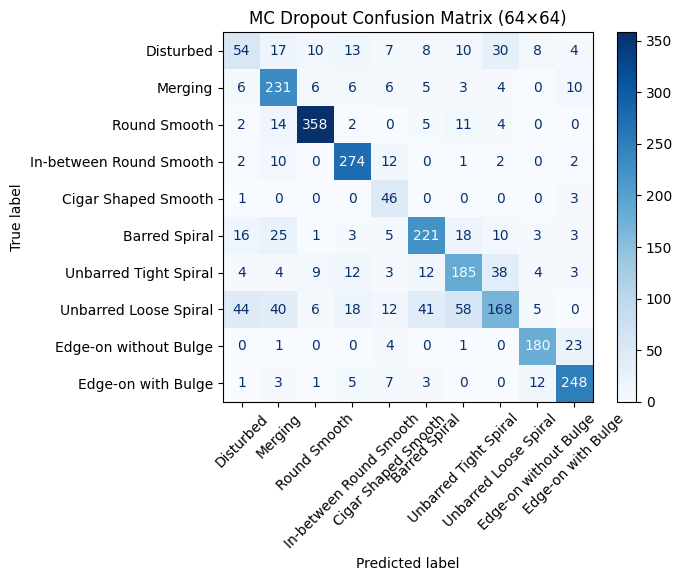

In [ ]:
# step 1c:Confusion Matrix(labels test and predicted labels)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('MC Dropout Confusion Matrix (64×64)')
plt.show()

Class 0: Accuracy = 0.335, Mean Entropy = 1.404
Class 1: Accuracy = 0.834, Mean Entropy = 0.970
Class 2: Accuracy = 0.904, Mean Entropy = 0.862
Class 3: Accuracy = 0.904, Mean Entropy = 0.871
Class 4: Accuracy = 0.920, Mean Entropy = 0.821
Class 5: Accuracy = 0.725, Mean Entropy = 1.103
Class 6: Accuracy = 0.675, Mean Entropy = 1.239
Class 7: Accuracy = 0.429, Mean Entropy = 1.436
Class 8: Accuracy = 0.861, Mean Entropy = 0.739
Class 9: Accuracy = 0.886, Mean Entropy = 0.676


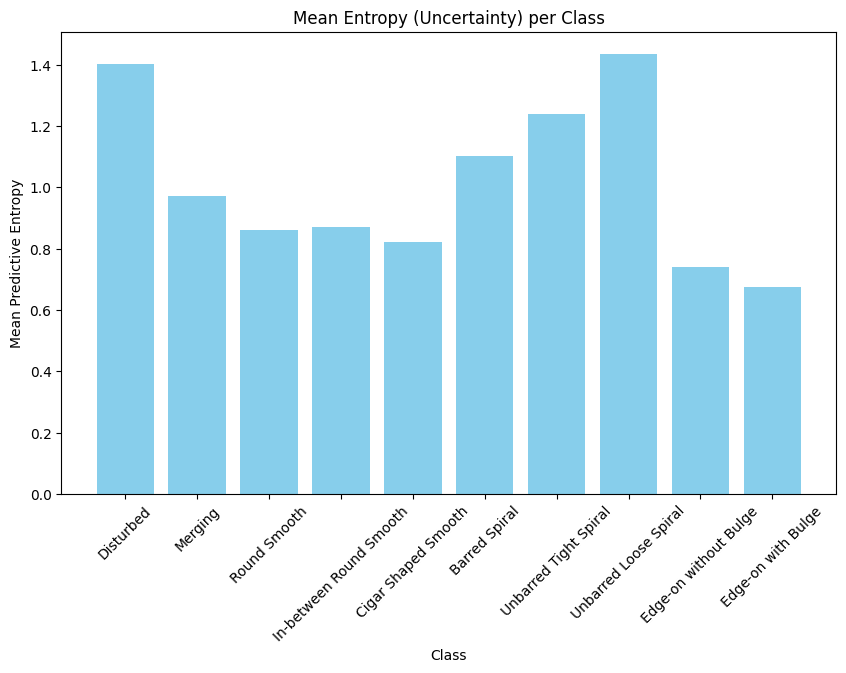

In [ ]:
# step 1d:Per-class accuracy and entropy(uncertainty) comparison
num_classes = len(np.unique(true_labels))
per_class_accuracy = []
mean_entropies = []

# Define uncertainty using the results from mc_dropout_predict
uncertainty = results['predictive_entropy']

for class_idx in range(num_classes):
    class_mask = true_labels == class_idx

    # Calculate per-class accuracy
    acc = np.mean(predicted_labels[class_mask] == true_labels[class_mask])
    per_class_accuracy.append(acc)
    #print(f"Class {class_idx} accuracy: {acc:.3f}")

    # Calculate mean predictive entropy
    mean_entropy = uncertainty[class_mask].mean()
    mean_entropies.append(mean_entropy)
    print(f"Class {class_idx}: Accuracy = {acc:.3f}, Mean Entropy = {mean_entropy:.3f}")


plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), mean_entropies, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Mean Predictive Entropy')
plt.title('Mean Entropy (Uncertainty) per Class')
plt.xticks(range(num_classes), class_names, rotation=45)
plt.show()

In [ ]:
#  step e: Detailed Classification Report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)


                         precision    recall  f1-score   support

              Disturbed       0.42      0.34      0.37       161
                Merging       0.67      0.83      0.74       277
           Round Smooth       0.92      0.90      0.91       396
In-between Round Smooth       0.82      0.90      0.86       303
    Cigar Shaped Smooth       0.45      0.92      0.61        50
          Barred Spiral       0.75      0.72      0.74       305
  Unbarred Tight Spiral       0.64      0.68      0.66       274
  Unbarred Loose Spiral       0.66      0.43      0.52       392
  Edge-on without Bulge       0.85      0.86      0.86       209
     Edge-on with Bulge       0.84      0.89      0.86       280

               accuracy                           0.74      2647
              macro avg       0.70      0.75      0.71      2647
           weighted avg       0.74      0.74      0.74      2647



In [ ]:
#2. Uncertainty Quantification Metrics(Quantify model/data uncertainty/MC Dropout)
# Predictive Entropy(Measures total uncertainty in prediction)
uncertainty = results['predictive_entropy']      # Total uncertainty(uncertainty/entropy)

# Mutual Information (Epistemic Uncertainty)
mutual_info = results['mutual_information']      # Model uncertainty/Epistemic uncertainty

# Aleatoric Uncertainty(noise inherent in input data, irreducible by more data)
aleatoric = results['aleatoric_entropy']     # Data uncertainty/Aleatoric uncertainty

print(f"\n UNCERTAINTY METRICS:")
print(f"Predictive entropy shape: {uncertainty.shape}")
print(f"Mutual information shape: {mutual_info.shape}")
print(f"Aleatoric uncertainty shape: {aleatoric.shape}")

print(f"\n UNCERTAINTY STATISTICS:")
print(f"Average predictive entropy: {np.mean(uncertainty):.4f}")
print(f"Average mutual information: {np.mean(mutual_info):.4f}")
print(f"Average aleatoric uncertainty: {np.mean(aleatoric):.4f}")
print(f"Uncertainty range: [{uncertainty.min():.4f}, {uncertainty.max():.4f}]")


 UNCERTAINTY METRICS:
Predictive entropy shape: (2647,)
Mutual information shape: (2647,)
Aleatoric uncertainty shape: (2647,)

 UNCERTAINTY STATISTICS:
Average predictive entropy: 1.0289
Average mutual information: 0.1554
Average aleatoric uncertainty: 0.8735
Uncertainty range: [0.0600, 2.0376]


Found 199 samples with high uncertainty and low confidence.


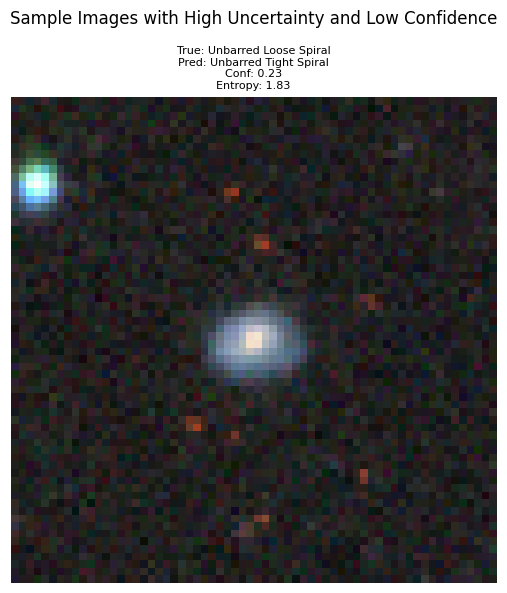

In [ ]:
# Define thresholds for high uncertainty and low confidence
# You can adjust these thresholds based on the distributions observed in the plots
uncertainty_threshold = np.percentile(results['predictive_entropy'], 90) # e.g., top 10% most uncertain
confidence_threshold = np.percentile(confidence_scores, 10) # e.g., bottom 10% least confident

# Find indices of samples meeting the criteria
high_uncertainty_low_confidence_indices = np.where(
    (results['predictive_entropy'] > uncertainty_threshold) &
    (confidence_scores < confidence_threshold)
)[0]

print(f"Found {len(high_uncertainty_low_confidence_indices)} samples with high uncertainty and low confidence.")

# Display a few sample images from these indices
num_samples_to_show = min(10, len(high_uncertainty_low_confidence_indices)) # Display up to 10 samples

if num_samples_to_show > 0:
    plt.figure(figsize=(15, 6))
    for i in range(num_samples_to_show):
        idx = high_uncertainty_low_confidence_indices[i]
        # Corrected: use 'test_images' instead of 'images_test'
        plt.imshow(test_images[idx][:, :, :3]) # Display RGB channels only for visualization
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[predicted_labels[idx]]}\nConf: {confidence_scores[idx]:.2f}\nEntropy: {results['predictive_entropy'][idx]:.2f}", fontsize=8)
        plt.axis('off')
    plt.suptitle('Sample Images with High Uncertainty and Low Confidence')
    plt.tight_layout()
    plt.show()
else:
    print("No samples found meeting the criteria.")

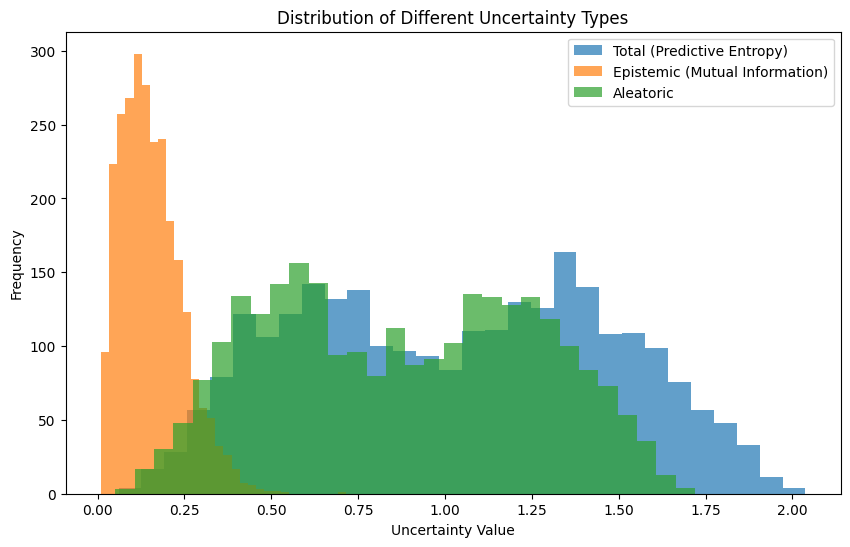

In [ ]:
# 3. Visualizations Related to Uncertainty
# Step 3a: Histogram of Uncertainty Distributions( all three)
plt.figure(figsize=(10,6))
plt.hist(uncertainty, bins=30, alpha=0.7, label='Total (Predictive Entropy)')
plt.hist(mutual_info, bins=30, alpha=0.7, label='Epistemic (Mutual Information)')
plt.hist(aleatoric, bins=30, alpha=0.7, label='Aleatoric')
plt.xlabel("Uncertainty Value")
plt.ylabel("Frequency")
plt.title("Distribution of Different Uncertainty Types")
plt.legend()
plt.show()

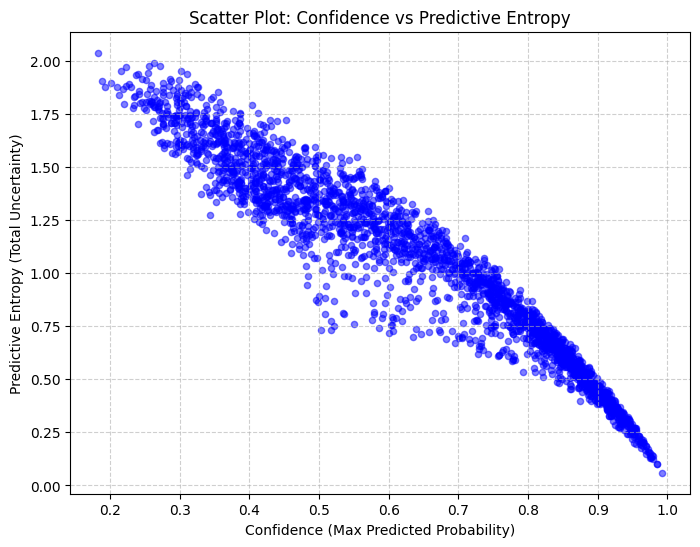

In [ ]:
# step 3b: Scatter plot: Confidence vs Predictive Entropy
plt.figure(figsize=(8,6))
plt.scatter(confidence_scores, uncertainty, alpha=0.5, s=20, c='blue')
plt.xlabel('Confidence (Max Predicted Probability)')
plt.ylabel('Predictive Entropy (Total Uncertainty)')
plt.title('Scatter Plot: Confidence vs Predictive Entropy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

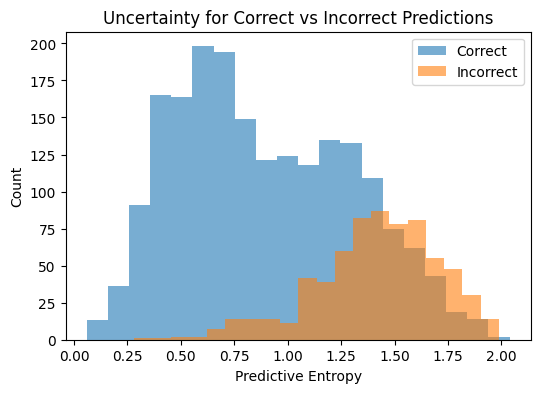

In [ ]:
# Step 3c: Compare Correct vs Incorrect Predictions
correct = (predicted_labels == true_labels)
plt.figure(figsize=(6,4))
plt.hist(uncertainty[correct], bins=20, alpha=0.6, label='Correct')
plt.hist(uncertainty[~correct], bins=20, alpha=0.6, label='Incorrect')
plt.xlabel('Predictive Entropy')
plt.ylabel('Count')
plt.legend()
plt.title('Uncertainty for Correct vs Incorrect Predictions')
plt.show()

/tmp/ipython-input-1080141530.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([uncertainty[correct], uncertainty[~correct]], labels=['Correct', 'Incorrect'],patch_artist=True,


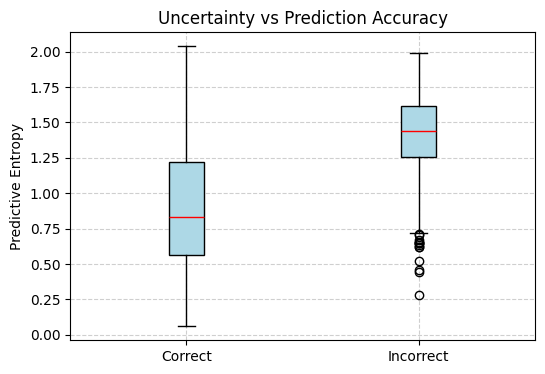

In [ ]:
# Boxplot: Uncertainty vs Correctness
correct = (predicted_labels == true_labels)
plt.figure(figsize=(6,4))
plt.boxplot([uncertainty[correct], uncertainty[~correct]], labels=['Correct', 'Incorrect'],patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='black'),
    medianprops=dict(color='red'))
plt.title('Uncertainty vs Prediction Accuracy')
plt.ylabel('Predictive Entropy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


predictions shape: (30, 2647, 10)
Average Variation Ratio: 0.1866263694748772


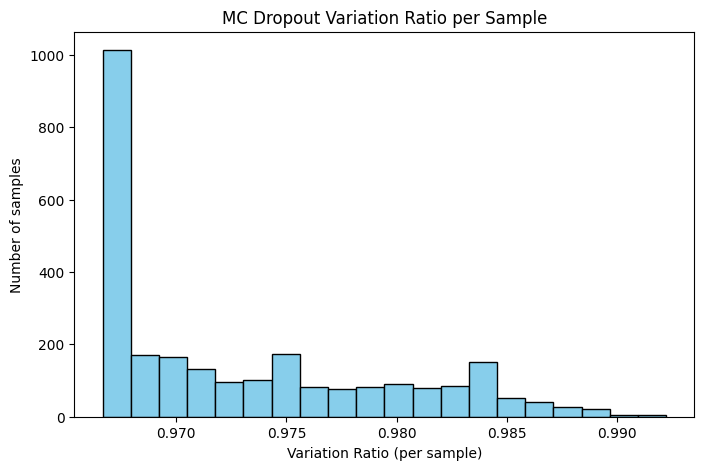

In [ ]:
# step 3d: Variation Ratio
# predictions: shape (num_mc_samples, num_test_samples, num_classes)
predictions = results['all_preds']
print(f"predictions shape: {predictions.shape}")
mc_classes = np.argmax(predictions, axis=2)  # shape: (num_mc_samples, num_test_samples)

# For each test sample, find the most common predicted class count
mode_counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=num_classes).max(), axis=0, arr=mc_classes)

variation_ratio = 1 - (mode_counts /predictions.shape[0])
print("Average Variation Ratio:", variation_ratio.mean())

# Compute variation ratio per test sample
num_test_samples = predictions.shape[1]
num_mc_samples = predictions.shape[0]
variation_ratio_per_sample = 1 - np.array([
    np.mean(mc_classes[:, i] == np.bincount(mc_classes[:, i]).argmax()) / num_mc_samples
    for i in range(num_test_samples)
])

# Histogram of variation ratios
plt.figure(figsize=(8,5))
plt.hist(variation_ratio_per_sample, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Variation Ratio (per sample)')
plt.ylabel('Number of samples')
plt.title('MC Dropout Variation Ratio per Sample')
plt.show()

Class 0 entropy: 1.4041191
Class 1 entropy: 0.9704883
Class 2 entropy: 0.8620621
Class 3 entropy: 0.87053275
Class 4 entropy: 0.8206341
Class 5 entropy: 1.1032863
Class 6 entropy: 1.2388691
Class 7 entropy: 1.435521
Class 8 entropy: 0.73938745
Class 9 entropy: 0.6755624


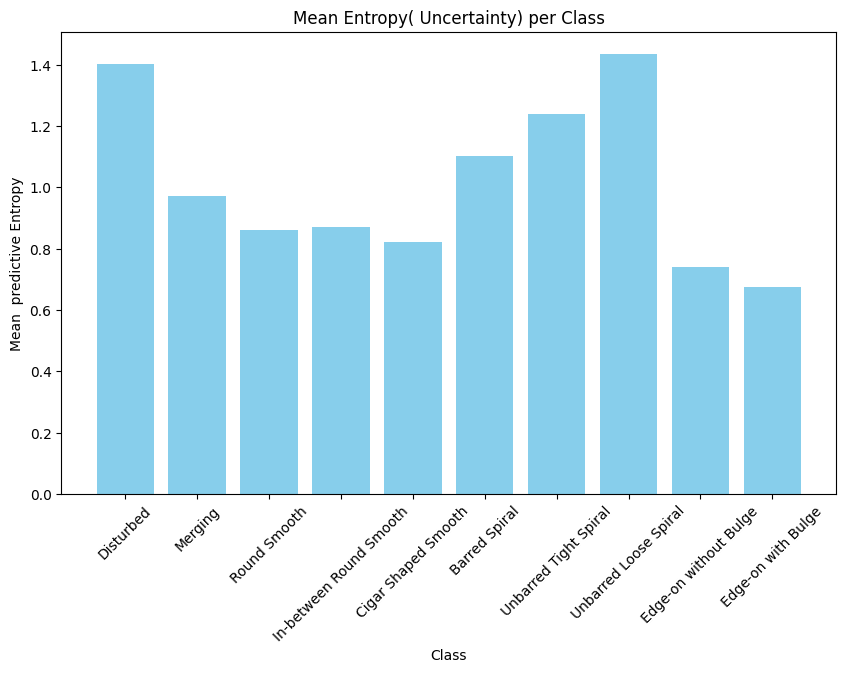

In [ ]:
# Per-Class Uncertainty(extra)

mean_entropies = []
for class_idx in range(num_classes):
    class_mask = (true_labels == class_idx)
    mean_entropy = uncertainty[class_mask].mean()
    mean_entropies.append(mean_entropy)
    print(f"Class {class_idx} entropy:", uncertainty[class_mask].mean())


plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), mean_entropies, color = 'skyblue')
plt.xlabel('Class')
plt.ylabel('Mean  predictive Entropy')
plt.title('Mean Entropy( Uncertainty) per Class')
plt.xticks(range(num_classes), class_names, rotation=45)
plt.show()

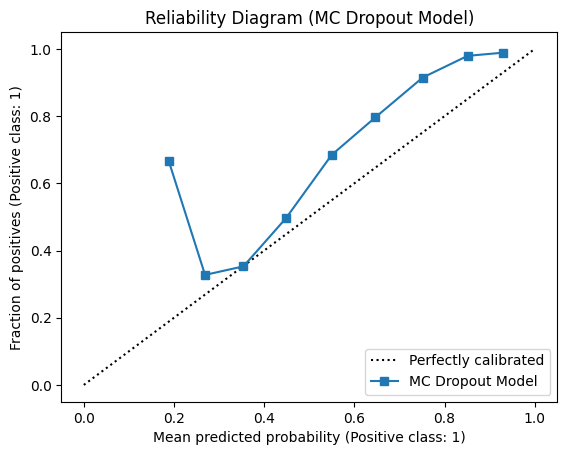

In [ ]:
# Step 4a: Reliability Diagram (Calibration Plot)
from sklearn.calibration import CalibrationDisplay
# Create true/false correctness per sample
correct = (predicted_labels == true_labels)

# Plot reliability diagram
disp = CalibrationDisplay.from_predictions(
    y_true=correct,
    y_prob=confidence_scores,
    n_bins=10,
    strategy='uniform',
    name='MC Dropout Model'
)
plt.title("Reliability Diagram (MC Dropout Model)")
plt.show()

In [ ]:
# Step 4b: Compute Expected Calibration Error (ECE)
def expected_calibration_error(y_true, y_prob, n_bins=10):
    """Compute Expected Calibration Error (ECE)."""
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    ece = 0.0

    for i in range(n_bins):
        bin_mask = binids == i
        if np.sum(bin_mask) > 0:
            bin_acc = np.mean(y_true[bin_mask])
            bin_conf = np.mean(y_prob[bin_mask])
            ece += np.abs(bin_acc - bin_conf) * np.sum(bin_mask) / len(y_true)
    return ece

# Compute ECE for MC Dropout model
ece_score = expected_calibration_error(correct, confidence_scores, n_bins=10)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")

Expected Calibration Error (ECE): 0.1001


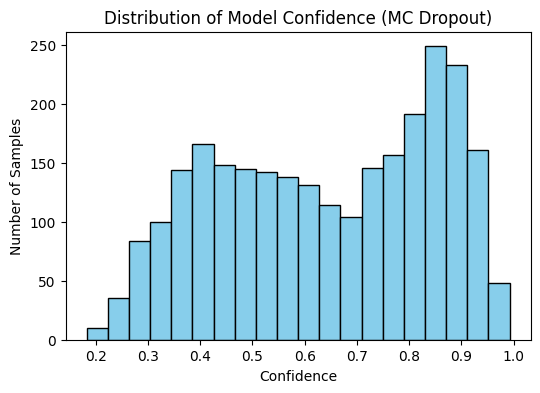

In [ ]:
# 4cHistogram of Confidence(optional)
plt.figure(figsize=(6,4))
plt.hist(confidence_scores, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Model Confidence (MC Dropout)')
plt.xlabel('Confidence')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
#2: MODEL VIT BASELINE(ViT-Baseline (4-channel))

from tensorflow.keras import layers, models
import tensorflow as tf

def build_vit_baseline(
        img_shape=(64, 64, 4),
        num_classes=10,
        patch_size=8,
        embed_dim=128,
        depth=4,
        num_heads=4,
        mlp_dim=256,
        dropout_rate=0.1):

    inputs = layers.Input(shape=img_shape, name="image_input")
    H, W, C = img_shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch_size"
    num_patches = (H // patch_size) * (W // patch_size)


    # 1. Patch Embedding (Conv2D → flatten)

    x = layers.Conv2D(
        filters=embed_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="patch_embedding"
    )(inputs)
    x = layers.Reshape((num_patches, embed_dim))(x)  # (B, N, D)


    # 2. Learnable CLS Token (proper init)

    cls_token_var = tf.Variable(
        tf.random.truncated_normal((1, 1, embed_dim), stddev=0.02),
        name="cls_token_var",
        trainable=True
    )
    # Fix: Wrap tf.broadcast_to in a Lambda layer
    cls = layers.Lambda(
        lambda inputs_x: tf.broadcast_to(cls_token_var, [tf.shape(inputs_x)[0], 1, embed_dim]),
        name="cls_token_broadcast"
    )(x)
    # Fix: Use layers.Concatenate instead of tf.concat
    x = layers.Concatenate(axis=1)([cls, x])  # (B, 1+N, D)

    # 3. Learnable Positional Embedding
    pos_emb = tf.Variable(
        tf.random.truncated_normal((1, 1 + num_patches, embed_dim), stddev=0.02),
        name="pos_embedding",
        trainable=True
    )
    x = layers.Add()([x, pos_emb])
    x = layers.Dropout(dropout_rate)(x)


    # 4. Transformer Blocks (Pre-Norm — Standard)

    for i in range(depth):
        # Attention
        shortcut = x
        x = layers.LayerNormalization(epsilon=1e-6, name=f"norm1_block{i}")(x)
        x = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout_rate,
            name=f"attention_block{i}"
        )(x, x)
        x = layers.Add(name=f"add1_block{i}")([shortcut, x])

        # MLP
        shortcut = x
        x = layers.LayerNormalization(epsilon=1e-6, name=f"norm2_block{i}")(x)
        x = layers.Dense(mlp_dim, activation="gelu", name=f"mlp_dense1_block{i}")(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Dense(embed_dim, name=f"mlp_dense2_block{i}")(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add(name=f"add2_block{i}")([shortcut, x])


    # 5. Global Representation: CLS token
    x = x[:, 0]  # Take CLS token → (B, D)


    # 6. Classification Head (with final LN — ViT standard)
    x = layers.LayerNormalization(epsilon=1e-6, name="final_ln")(x)
    x = layers.Dense(256, activation="gelu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)


    # Final Model
    return models.Model(inputs, outputs, name="ViT-Baseline-4ch")

In [ ]:
# Build model
model_b= build_vit_baseline(img_shape=(64, 64, 4), num_classes=10)

model_b.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_b.summary()

Model: "ViT-Baseline-4ch"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 8, 8, 128) │     32,896 │ image_input[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 64, 128)   │          0 │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_token_broadcast │ (None, 1, 128)    │          0 │ reshape_3[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 65, 128)   │          0 │ cls_token_broadc… │
│ (Concatenate)       │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (1, 65, 128)      │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_63          │ (1, 65, 128)      │          0 │ add_39[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm1_block0        │ (1, 65, 128)      │        256 │ dropout_63[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_block0    │ (1, 65, 128)      │     66,048 │ norm1_block0[0][… │
│ (MultiHeadAttentio… │                   │            │ norm1_block0[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add1_block0 (Add)   │ (1, 65, 128)      │          0 │ dropout_63[0][0], │
│                     │                   │            │ attention_block0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm2_block0        │ (1, 65, 128)      │        256 │ add1_block0[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_dense1_block0   │ (1, 65, 256)      │     33,024 │ norm2_block0[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (1, 65, 256)      │          0 │ mlp_dense1_block… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_dense2_block0   │ (1, 65, 128)      │     32,896 │ dropout_65[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (1, 65, 128)      │          0 │ mlp_dense2_block… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add2_block0 (Add)   │ (1, 65, 128)      │          0 │ add1_block0[0][0… │
│                     │                   │            │ dropout_66[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm1_block1        │ (1, 65, 128)      │        256 │ add2_block0[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 598,666 (2.28 MB)

 Trainable params: 598,666 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks (EarlyStopping, LR scheduling, checkpoint)
callbacks_b= [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/modelB_vit_mc_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [ ]:
# Train the model
history = model_b.fit(train_ds,
                    validation_data=val_ds,
                    epochs=70,
                    callbacks=callbacks_b,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    verbose=1)

Epoch 1/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 2s 708ms/step - accuracy: 0.1076 - loss: 2.3852
Epoch 1: val_accuracy improved from -inf to 0.16818, saving model to models/modelB_vit_mc_best.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 84s 754ms/step - accuracy: 0.1081 - loss: 2.3831 - val_accuracy: 0.1682 - val_loss: 2.2754 - learning_rate: 1.0000e-04
Epoch 2/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step - accuracy: 0.1386 - loss: 2.2726
Epoch 2: val_accuracy did not improve from 0.16818
73/73 ━━━━━━━━━━━━━━━━━━━━ 36s 476ms/step - accuracy: 0.1391 - loss: 2.2721 - val_accuracy: 0.1621 - val_loss: 2.2318 - learning_rate: 1.0000e-04
Epoch 3/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step - accuracy: 0.1550 - loss: 2.2521
Epoch 3: val_accuracy improved from 0.16818 to 0.20711, saving model to models/modelB_vit_mc_best.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 37s 487ms/step - accuracy: 0.1552 - loss: 2.2515 - val_accuracy: 0.2071 - val_loss: 2.1863 - learning_rate: 1.0000e-04
Epoch 4/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/s

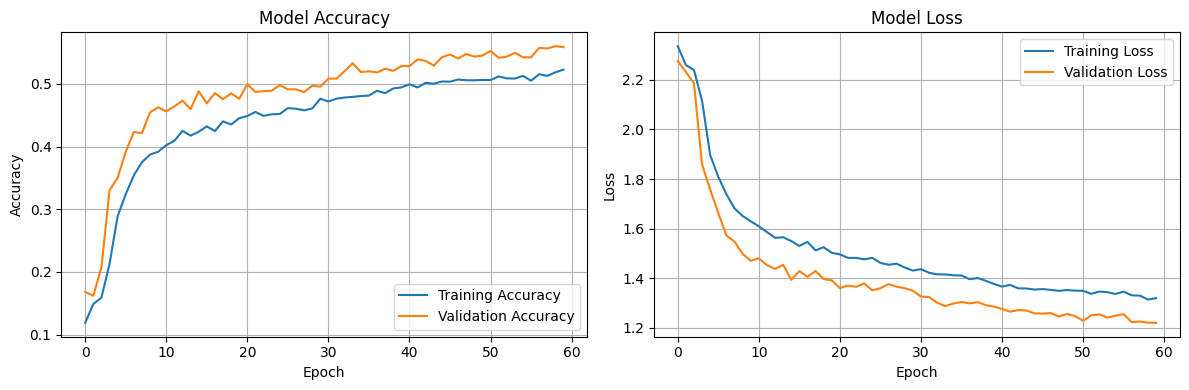

In [ ]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf
#2: model vit_mc
def build_vit_mc(
        img_shape=(64, 64, 4),
        num_classes=10,
        patch_size=8,
        embed_dim=128,
        depth=4,
        num_heads=4,
        mlp_dim=256,
        dropout_rate=0.1,
        head_dropout=0.3):

    # 1) Input
    inputs = layers.Input(shape=img_shape, name="image_input")
    H, W, C = img_shape
    assert H % patch_size == 0 and W % patch_size == 0, "H,W must be divisible by patch_size"

    num_patches = (H // patch_size) * (W // patch_size)

    # 2) Patch embedding: Conv2D \u2192 (B, N, D)
    x = layers.Conv2D(
        filters=embed_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="patch_embedding",
    )(inputs)                            # (B, H/ps, W/ps, D)
    x = layers.Reshape((num_patches, embed_dim))(x)  # (B, N, D)

    # 3) Learnable CLS Token (proper init) similar to build_vit_baseline
    cls_token_var = tf.Variable(
        tf.random.truncated_normal((1, 1, embed_dim), stddev=0.02),
        name="cls_token_var",
        trainable=True
    )
    cls = layers.Lambda(
        lambda inputs_x: tf.broadcast_to(cls_token_var, [tf.shape(inputs_x)[0], 1, embed_dim]),
        name="cls_token_broadcast"
    )(x)
    x = layers.Concatenate(axis=1)([cls, x])  # (B, 1+N, D)

    # 4) Learnable Positional Embedding
    pos_emb = tf.Variable(
        tf.random.truncated_normal((1, 1 + num_patches, embed_dim), stddev=0.02),
        name="pos_embedding",
        trainable=True
    )
    x = layers.Add()([x, pos_emb])
    x = layers.Dropout(dropout_rate)(x)

    # 5) Transformer encoder blocks (pre-norm)
    for i in range(depth):
        # --- Multi-Head Self-Attention block ---
        shortcut = x
        x_norm = layers.LayerNormalization(epsilon=1e-6, name=f"encoder_norm1_{i}")(x)
        attn_out = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout_rate,
            name=f"encoder_mhsa_{i}",
        )(x_norm, x_norm)   # NO training=True here
        x = layers.Add(name=f"encoder_attn_add_{i}")([shortcut, attn_out])

        # --- MLP block ---
        shortcut = x
        x_norm = layers.LayerNormalization(epsilon=1e-6, name=f"encoder_norm2_{i}")(x)
        mlp = layers.Dense(mlp_dim, activation="gelu", name=f"encoder_mlp1_{i}")(x_norm)
        mlp = layers.Dropout(dropout_rate, name=f"encoder_mlp_drop1_{i}")(mlp)
        mlp = layers.Dense(embed_dim, name=f"encoder_mlp2_{i}")(mlp)
        mlp = layers.Dropout(dropout_rate, name=f"encoder_mlp_drop2_{i}")(mlp)
        x = layers.Add(name=f"encoder_mlp_add_{i}")([shortcut, mlp])

    # 6) CLS token representation
    cls_token_out = layers.Lambda(lambda t: t[:, 0], name="cls_extract")(x)  # (B, D)

    # 7) Classification head with MC-Dropout
    #    (MC comes from calling model(..., training=True) at inference)
    h = layers.LayerNormalization(epsilon=1e-6, name="head_ln")(cls_token_out)
    h = layers.Dense(256, activation="gelu", name="head_dense1")(h)
    h = layers.Dropout(head_dropout, name="head_drop1")(h)      # MC-Dropout location
    h = layers.Dense(128, activation="gelu", name="head_dense2")(h)
    h = layers.Dropout(head_dropout, name="head_drop2")(h)      # MC-Dropout location

    # LOGITS (no softmax here)
    logits = layers.Dense(num_classes, name="logits")(h)

    model = models.Model(inputs, logits, name="ViT_MC_4ch")
    return model

In [ ]:
#4 Build model
vit_mc = build_vit_mc(
    img_shape=(64, 64, 4),
    num_classes=10,
    patch_size=8,
    embed_dim=128,
    depth=4,
    num_heads=4,
    mlp_dim=256,
    dropout_rate=0.1,
    head_dropout=0.3
)

vit_mc.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

vit_mc.summary()


Model: "ViT_MC_4ch"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 64, 64, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 8, 8, 128) │     32,896 │ image_input[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 128)   │          0 │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_token_broadcast │ (None, 1, 128)    │          0 │ reshape[0][0]     │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 65, 128)   │          0 │ cls_token_broadc… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (1, 65, 128)      │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (1, 65, 128)      │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_norm1_0     │ (1, 65, 128)      │        256 │ dropout[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mhsa_0      │ (1, 65, 128)      │     66,048 │ encoder_norm1_0[… │
│ (MultiHeadAttentio… │                   │            │ encoder_norm1_0[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_attn_add_0  │ (1, 65, 128)      │          0 │ dropout[0][0],    │
│ (Add)               │                   │            │ encoder_mhsa_0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_norm2_0     │ (1, 65, 128)      │        256 │ encoder_attn_add… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mlp1_0      │ (1, 65, 256)      │     33,024 │ encoder_norm2_0[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mlp_drop1_0 │ (1, 65, 256)      │          0 │ encoder_mlp1_0[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mlp2_0      │ (1, 65, 128)      │     32,896 │ encoder_mlp_drop… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mlp_drop2_0 │ (1, 65, 128)      │          0 │ encoder_mlp2_0[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mlp_add_0   │ (1, 65, 128)      │          0 │ encoder_attn_add… │
│ (Add)               │                   │            │ encoder_mlp_drop… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_norm1_1     │ (1, 65, 128)      │        256 │ encoder_mlp_add_… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_mhsa_1      │ (1, 65, 128)      │     66,048 │ encoder_norm1_1[

 Total params: 630,282 (2.40 MB)

 Trainable params: 630,282 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks (EarlyStopping, LR scheduling, checkpoint)
callbacks_c= [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/modelB_vit_mc_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [ ]:
history_vit_mc = vit_mc.fit(
    train_ds,                             # your repeated+augmented dataset
    epochs=60,
    validation_data=val_ds,
    callbacks=callbacks_c,
    steps_per_epoch=STEPS_PER_EPOCH,     # your EarlyStopping / ReduceLRO / Checkpoint
    verbose=1
    )

Epoch 1/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 2s 804ms/step - accuracy: 0.1068 - loss: 2.3659

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.16931, saving model to models/modelB_vit_mc_best.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 104s 856ms/step - accuracy: 0.1071 - loss: 2.3643 - val_accuracy: 0.1693 - val_loss: 2.2607 - learning_rate: 1.0000e-04
Epoch 2/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - accuracy: 0.1391 - loss: 2.2841
Epoch 2: val_accuracy improved from 0.16931 to 0.17763, saving model to models/modelB_vit_mc_best.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 541ms/step - accuracy: 0.1393 - loss: 2.2837 - val_accuracy: 0.1776 - val_loss: 2.2224 - learning_rate: 1.0000e-04
Epoch 3/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step - accuracy: 0.1465 - loss: 2.2577
Epoch 3: val_accuracy did not improve from 0.17763
73/73 ━━━━━━━━━━━━━━━━━━━━ 39s 514ms/step - accuracy: 0.1469 - loss: 2.2574 - val_accuracy: 0.1689 - val_loss: 2.2141 - learning_rate: 1.0000e-04
Epoch 4/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - accuracy: 0.1588 - loss: 2.2380
Epoch 4: val_accuracy did not improve from 0.1

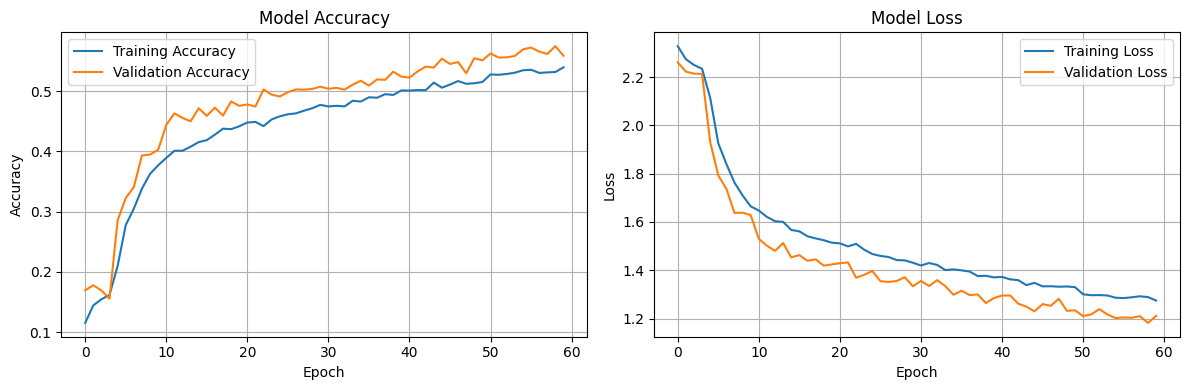

In [ ]:
def plot_training_history(history_vit_mc):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history_vit_mc.history['accuracy'], label='Training Accuracy')
    ax1.plot(history_vit_mc.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    # Plot loss
    ax2.plot(history_vit_mc.history['loss'], label='Training Loss')
    ax2.plot(history_vit_mc.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history_vit_mc)


In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# def build_convnext_tiny_mc(img_shape=(64,64,4), num_classes=10, dropout_rate=0.2):

#     inputs = layers.Input(shape=img_shape)

#     # ---------------------------------------------------------
#     # STEM: Patchify 4×4 → 16×16 grid
#     # ---------------------------------------------------------
#     x = layers.Conv2D(96, kernel_size=4, strides=4, padding="valid",
#                       name="stem_conv")(inputs)
#     x = layers.LayerNormalization(epsilon=1e-6, name="stem_ln")(x)

#     # ---------------------------------------------------------
#     # STAGE 1 (ConvNeXt Block × 3)
#     # Feature map: 16×16, channels: 96
#     # ---------------------------------------------------------
#     for i in range(3):
#         residual = x

#         # Depthwise 7×7
#         x = layers.Conv2D(96, kernel_size=7, padding="same", groups=96,
#                           name=f"stage1_dw_{i}")(x)

#         x = layers.LayerNormalization(epsilon=1e-6, name=f"stage1_ln_{i}")(x)

#         # MLP expansion 4×
#         x = layers.Dense(384, activation="gelu", name=f"stage1_mlp1_{i}")(x)
#         x = layers.Dropout(dropout_rate, name=f"stage1_mc_{i}")(x, training=True)

#         # MLP projection
#         x = layers.Dense(96, name=f"stage1_mlp2_{i}")(x)

#         # Skip
#         x = layers.Add(name=f"stage1_add_{i}")([x, residual])


#     # ---------------------------------------------------------
#     # STAGE 2 (Downsample + Block × 3)
#     # Feature map: 8×8, channels: 192
#     # ---------------------------------------------------------
#     x = layers.LayerNormalization(epsilon=1e-6, name="stage2_down_ln")(x)
#     x = layers.Conv2D(192, kernel_size=2, strides=2, name="stage2_down")(x)

#     for i in range(3):
#         residual = x
#         x = layers.Conv2D(192, 7, padding="same", groups=192,
#                           name=f"stage2_dw_{i}")(x)

#         x = layers.LayerNormalization(epsilon=1e-6, name=f"stage2_ln_{i}")(x)

#         x = layers.Dense(768, activation="gelu", name=f"stage2_mlp1_{i}")(x)
#         x = layers.Dropout(dropout_rate, name=f"stage2_mc_{i}")(x, training=True)

#         x = layers.Dense(192, name=f"stage2_mlp2_{i}")(x)
#         x = layers.Add(name=f"stage2_add_{i}")([x, residual])


#     # ---------------------------------------------------------
#     # STAGE 3 (Downsample + Block × 9)
#     # Feature map: 4×4, channels: 384
#     # ---------------------------------------------------------
#     x = layers.LayerNormalization(epsilon=1e-6, name="stage3_down_ln")(x)
#     x = layers.Conv2D(384, kernel_size=2, strides=2, name="stage3_down")(x)

#     for i in range(9):
#         residual = x
#         x = layers.Conv2D(384, 7, padding="same", groups=384,
#                           name=f"stage3_dw_{i}")(x)

#         x = layers.LayerNormalization(epsilon=1e-6, name=f"stage3_ln_{i}")(x)

#         x = layers.Dense(1536, activation="gelu", name=f"stage3_mlp1_{i}")(x)
#         x = layers.Dropout(dropout_rate, name=f"stage3_mc_{i}")(x, training=True)

#         x = layers.Dense(384, name=f"stage3_mlp2_{i}")(x)
#         x = layers.Add(name=f"stage3_add_{i}")([x, residual])


#     # ---------------------------------------------------------
#     # HEAD
#     # ---------------------------------------------------------
#     x = layers.GlobalAveragePooling2D(name="head_gap")(x)
#     x = layers.LayerNormalization(epsilon=1e-6, name="head_ln")(x)

#     x = layers.Dense(128, activation="gelu", name="head_dense")(x)
#     x = layers.Dropout(0.3, name="head_mc")(x, training=True)

#     outputs = layers.Dense(num_classes, name="head_logits")(x)

#     return models.Model(inputs, outputs, name="ConvNeXt_Tiny_MC")


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


# ----------------------------------------------------
#  ConvNeXt Block (with MC-Dropout inside)
# ----------------------------------------------------
def convnext_block(x, filters, drop_rate, mc_dropout, name_prefix=""):
    residual = x

    # Depthwise Conv (7×7)
    x = layers.Conv2D(
        filters, kernel_size=7, padding="same", groups=filters,
        name=f"{name_prefix}_dwconv"
    )(x)

    # LayerNorm
    x = layers.LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_ln")(x)

    # Pointwise MLP (expansion → GELU → projection)
    x = layers.Dense(filters * 4, activation="gelu", name=f"{name_prefix}_mlp_expand")(x)
    x = layers.Dropout(drop_rate, name=f"{name_prefix}_mlp_dropout")(x, training=mc_dropout)
    x = layers.Dense(filters, name=f"{name_prefix}_mlp_project")(x)

    # Residual connection
    return layers.Add(name=f"{name_prefix}_add")([residual, x])


# ----------------------------------------------------
#  ConvNeXt-Tiny MC Model
# ----------------------------------------------------
def build_convnext_tiny_mc(img_shape=(64, 64, 4), num_classes=10,
                           drop_rate=0.2, mc_dropout=True):

    inputs = layers.Input(shape=img_shape)

    # -------------------------------
    # 1. Stem: Patchify (4×4 stride)
    # -------------------------------
    x = layers.Conv2D(96, kernel_size=4, strides=4, padding="valid", name="stem_conv")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6, name="stem_ln")(x)

    # -------------------------------
    # 2. Stage 1 (96 filters × 3 blocks)
    # -------------------------------
    for i in range(3):
        x = convnext_block(x, 96, drop_rate, mc_dropout, name_prefix=f"stage1_block{i}")

    # -------------------------------
    # 3. Stage 2 (downsample → 192)
    # -------------------------------
    x = layers.LayerNormalization(epsilon=1e-6, name="stage2_down_ln")(x)
    x = layers.Conv2D(192, kernel_size=2, strides=2, name="stage2_downsample")(x)

    for i in range(3):
        x = convnext_block(x, 192, drop_rate, mc_dropout, name_prefix=f"stage2_block{i}")

    # -------------------------------
    # 4. Stage 3 (downsample → 384)
    # -------------------------------
    x = layers.LayerNormalization(epsilon=1e-6, name="stage3_down_ln")(x)
    x = layers.Conv2D(384, kernel_size=2, strides=2, name="stage3_downsample")(x)

    for i in range(9):
        x = convnext_block(x, 384, drop_rate, mc_dropout, name_prefix=f"stage3_block{i}")

    # -------------------------------
    # 5. Classification Head
    # -------------------------------
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.LayerNormalization(epsilon=1e-6, name="head_ln")(x)
    x = layers.Dense(128, activation="gelu", name="head_dense")(x)
    x = layers.Dropout(0.3, name="head_dropout")(x, training=mc_dropout)

    outputs = layers.Dense(num_classes, name="logits")(x)  # logits for MC

    model = models.Model(inputs, outputs, name="ConvNeXtTiny_MC")
    return model


In [ ]:
model_d = build_convnext_tiny_mc(img_shape=(64,64,4), num_classes=10)

model_d.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model_d.summary()

Model: "ConvNeXtTiny_MC"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 64, 64, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 16, 16,    │      6,240 │ input_layer_5[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_ln             │ (None, 16, 16,    │        192 │ stem_conv[0][0]   │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_dwco… │ (None, 16, 16,    │      4,800 │ stem_ln[0][0]     │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_ln    │ (None, 16, 16,    │        192 │ stage1_block0_dw… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_mlp_… │ (None, 16, 16,    │     37,248 │ stage1_block0_ln… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_mlp_… │ (None, 16, 16,    │          0 │ stage1_block0_ml… │
│ (Dropout)           │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_mlp_… │ (None, 16, 16,    │     36,960 │ stage1_block0_ml… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_add   │ (None, 16, 16,    │          0 │ stem_ln[0][0],    │
│ (Add)               │ 96)               │            │ stage1_block0_ml… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_dwco… │ (None, 16, 16,    │      4,800 │ stage1_block0_ad… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_ln    │ (None, 16, 16,    │        192 │ stage1_block1_dw… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_mlp_… │ (None, 16, 16,    │     37,248 │ stage1_block1_ln… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_mlp_… │ (None, 16, 16,    │          0 │ stage1_block1_ml… │
│ (Dropout)           │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_mlp_… │ (None, 16, 16,    │     36,960 │ stage1_block1_ml… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_add   │ (None, 16, 16,    │          0 │ stage1_block0_ad… │
│ (Add)               │ 96)               │            │ stage1_block1_ml… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_dwco… │ (None, 16, 16,    │      4,800 │ stage1_block1_ad… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block2_ln    │ (None, 16, 16,    │        192 │ stage1_block2_dw

 Total params: 12,396,554 (47.29 MB)

 Trainable params: 12,396,554 (47.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks (EarlyStopping, LR scheduling, checkpoint)
callbacks_d= [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/modelB_vit_mc_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [ ]:


history_d = model_d.fit(
    train_ds,      # Use the batched dataset
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks_d,
    steps_per_epoch=STEPS_PER_EPOCH,     # your EarlyStopping / ReduceLRO / Checkpoint
    verbose=1
)

Epoch 1/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - accuracy: 0.1078 - loss: 2.4302

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.07861, saving model to models/modelB_vit_mc_best.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.1079 - loss: 2.4265 - val_accuracy: 0.0786 - val_loss: 2.3087 - learning_rate: 1.0000e-04
Epoch 2/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1239 - loss: 2.2886
Epoch 2: val_accuracy improved from 0.07861 to 0.13190, saving model to models/modelB_vit_mc_best.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.1245 - loss: 2.2880 - val_accuracy: 0.1319 - val_loss: 2.2745 - learning_rate: 1.0000e-04
Epoch 3/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1441 - loss: 2.2663
Epoch 3: val_accuracy improved from 0.13190 to 0.16667, saving model to models/modelB_vit_mc_best.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.1445 - loss: 2.2658 - val_accuracy: 0.1667 - val_loss: 2.2360 - learning_rate: 1.0000e-04
Epoch 4/60
70/73 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.1622 - loss: 2.2401
Epoch 4: 